<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
</div>

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from scipy.stats import chi2_contingency, pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Chargements des fichiers</h3>
</div>

In [ ]:
df_customers = pd.read_csv("Data/customers.csv", sep=";")
df_products = pd.read_csv("Data/products.csv", sep=";")
df_transactions = pd.read_csv("Data/Transactions.csv", sep=";")

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_14132\1975717705.py:3: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_transactions = pd.read_csv("Data/Transactions.csv", sep=";")


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Analyse exploratoire des fichiers</h2>
</div>

In [ ]:
df_customers

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8616,c_7920,m,1956
8617,c_7403,f,1970
8618,c_5119,m,1974
8619,c_5643,f,1968


In [ ]:
current_year = datetime.now().year
df_customers['age'] = current_year - df_customers['birth']
del df_customers['birth']

In [ ]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   age        8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [ ]:
df_products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3281,2_23,115.99,2
3282,0_146,17.14,0
3283,0_802,11.22,0
3284,1_140,38.56,1


In [ ]:
df_transactions

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
1048570,NaN,NaN,NaN,NaN
1048571,NaN,NaN,NaN,NaN
1048572,NaN,NaN,NaN,NaN
1048573,NaN,NaN,NaN,NaN


In [ ]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     687534 non-null  object
 1   date        687534 non-null  object
 2   session_id  687534 non-null  object
 3   client_id   687534 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [ ]:
# Nombre total de lignes dans transactions
total_rows_transactions = df_transactions.shape[0]

# Nombre de lignes contenant uniquement des NaN
na_rows_transactions = df_transactions[df_transactions.isna().all(axis=1)].shape[0]

# Calcul du pourcentage
percentage_na_transactions = (na_rows_transactions / total_rows_transactions) * 100

print(f"Nombre de lignes qui seront supprimées : {na_rows_transactions}")
print(f"Ce qui équivaut à : {percentage_na_transactions:.2f}% de la table")
del total_rows_transactions
del na_rows_transactions
del percentage_na_transactions

Nombre de lignes qui seront supprimées : 361041
Ce qui équivaut à : 34.43% de la table


In [ ]:
df_transactions.dropna(how='all', inplace=True)
df_transactions

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848


In [ ]:
#Vérifier les client_id avec une regex
import re

# Définir une fonction pour vérifier le format
def check_format(client_id):
    # Vérifier si le client_id correspond au format attendu
    if pd.isna(client_id):
        return "NaN"
    elif re.match(r'^c_\d+$', str(client_id)):
        return "Valid"
    else:
        return "Invalid"

# Appliquer la fonction à la colonne client_id
df_transactions['format_check'] = df_transactions['client_id'].apply(check_format)

# Compter les valeurs "Invalid" et "NaN"
invalid_ids = df_transactions[df_transactions['format_check'] == "Invalid"]
nan_ids = df_transactions[df_transactions['format_check'] == "NaN"]

print(f"Nombre de IDs invalides : {invalid_ids.shape[0]}")
print(f"Nombre de NaN : {nan_ids.shape[0]}")


Nombre de IDs invalides : 0
Nombre de NaN : 0


In [ ]:
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

In [ ]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687534 entries, 0 to 687533
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id_prod       687534 non-null  object        
 1   date          687534 non-null  datetime64[ns]
 2   session_id    687534 non-null  object        
 3   client_id     687534 non-null  object        
 4   format_check  687534 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 31.5+ MB


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Analyse des données</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1 - Évolution du chiffre d'affaires</h3>
</div>

In [ ]:
# Fusionner transactions avec produits pour obtenir les prix
df_transactions_products = df_transactions.merge(df_products,how="outer", on='id_prod', indicator=True)

In [ ]:
df_transactions_products

,id_prod,date,session_id,client_id,format_check,price,categ,_merge
0,0_0,2021-03-01 13:45:51.575117,s_282,c_5152,Valid,3.75,0,both
1,0_0,2021-03-02 06:42:55.351333,s_621,c_2917,Valid,3.75,0,both
2,0_0,2021-03-02 18:49:49.651862,s_852,c_3988,Valid,3.75,0,both
3,0_0,2021-03-02 21:57:33.862118,s_908,c_1004,Valid,3.75,0,both
4,0_0,2021-03-03 23:59:48.997483,s_1379,c_278,Valid,3.75,0,both
...,...,...,...,...,...,...,...,...
687550,2_99,2022-05-21 01:53:46.967570,s_211661,c_5828,Valid,84.99,2,both
687551,2_99,2022-07-21 01:53:46.967570,s_241374,c_5828,Valid,84.99,2,both
687552,2_99,2022-11-11 20:56:49.820935,s_296127,c_7135,Valid,84.99,2,both
687553,2_99,2022-12-11 20:56:49.820935,s_310606,c_7135,Valid,84.99,2,both


In [ ]:
#Y a t-il des lignes ne "matchant" entre les 2 fichiers?
df_transactions_products['_merge'].value_counts()
#NON

_merge
both          687534
right_only        21
left_only          0
Name: count, dtype: int64

In [ ]:
# Calculer le pourcentage des données mises de côté
per_invite = (df_transactions_products['_merge'].value_counts()['right_only'] / df_transactions_products['_merge'].value_counts()['both']) * 100

print(f'Nous avons décidé de laisser de côté {per_invite:.3f}% des données pour éviter les erreurs en attendant la confirmation du client.')


Nous avons décidé de laisser de côté 0.003% des données pour éviter les erreurs en attendant la confirmation du client.


In [ ]:
# Clean (Pour l'instant on décide d'extraire ces données, en attendant la confirmation du client, cela va nous permettre de continuer notre analyse)
df_invite = df_transactions_products[df_transactions_products["_merge"]=='right_only']
del df_invite['_merge']
df_transactions_products = df_transactions_products[df_transactions_products["_merge"]=='both']
del df_transactions_products['_merge']

In [ ]:
df_invite

,id_prod,date,session_id,client_id,format_check,price,categ
6073,0_1014,NaT,NaN,NaN,NaN,1.15,0
6511,0_1016,NaT,NaN,NaN,NaN,35.06,0
8723,0_1025,NaT,NaN,NaN,NaN,24.99,0
21687,0_1062,NaT,NaN,NaN,NaN,20.08,0
40971,0_1119,NaT,NaN,NaN,NaN,2.99,0
94245,0_1318,NaT,NaN,NaN,NaN,20.92,0
297077,0_1620,NaT,NaN,NaN,NaN,0.80,0
299185,0_1624,NaT,NaN,NaN,NaN,24.50,0
311123,0_1645,NaT,NaN,NaN,NaN,2.99,0
323013,0_1780,NaT,NaN,NaN,NaN,1.67,0


In [ ]:
df_transactions_products

,id_prod,date,session_id,client_id,format_check,price,categ
0,0_0,2021-03-01 13:45:51.575117,s_282,c_5152,Valid,3.75,0
1,0_0,2021-03-02 06:42:55.351333,s_621,c_2917,Valid,3.75,0
2,0_0,2021-03-02 18:49:49.651862,s_852,c_3988,Valid,3.75,0
3,0_0,2021-03-02 21:57:33.862118,s_908,c_1004,Valid,3.75,0
4,0_0,2021-03-03 23:59:48.997483,s_1379,c_278,Valid,3.75,0
...,...,...,...,...,...,...,...
687550,2_99,2022-05-21 01:53:46.967570,s_211661,c_5828,Valid,84.99,2
687551,2_99,2022-07-21 01:53:46.967570,s_241374,c_5828,Valid,84.99,2
687552,2_99,2022-11-11 20:56:49.820935,s_296127,c_7135,Valid,84.99,2
687553,2_99,2022-12-11 20:56:49.820935,s_310606,c_7135,Valid,84.99,2


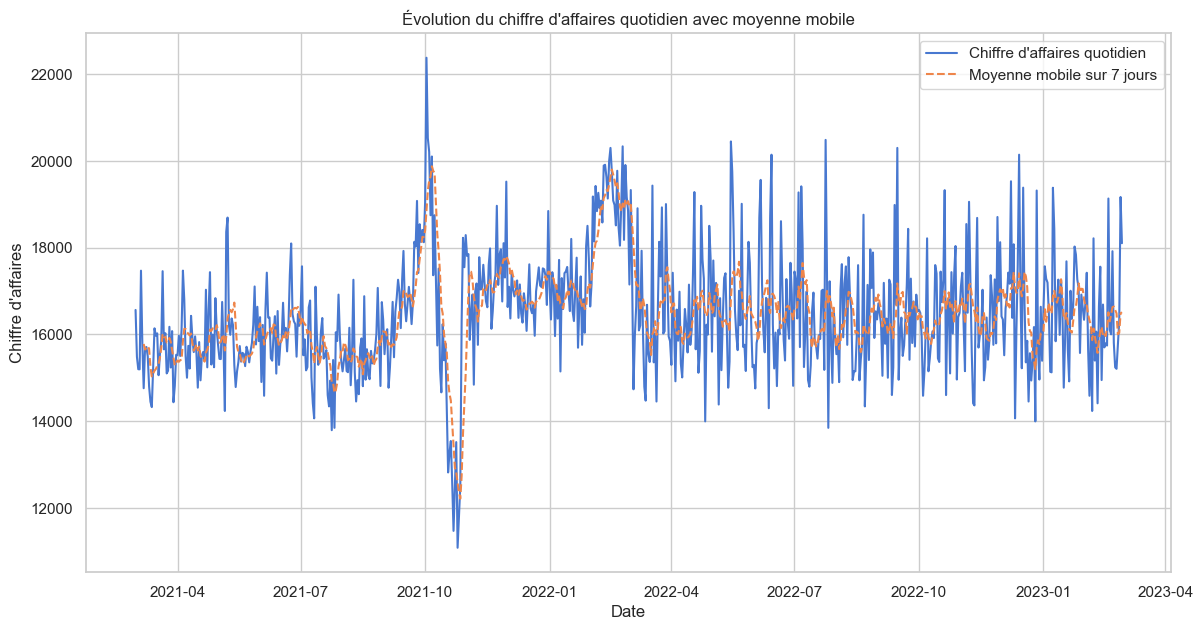

In [ ]:
# Calculer le chiffre d'affaires par jour et ajouter une moyenne mobile
daily_revenue = df_transactions_products.groupby(df_transactions_products['date'].dt.date)['price'].sum()
daily_revenue = daily_revenue.to_frame(name='daily_revenue')
daily_revenue['7d_moving_avg'] = daily_revenue['daily_revenue'].rolling(window=7).mean()


#Palette de couleurs
sns.set_theme(style='whitegrid', palette='muted')

# Tracer le graphique
plt.figure(figsize=(14, 7))
plt.plot(daily_revenue.index, daily_revenue['daily_revenue'], label="Chiffre d'affaires quotidien")
plt.plot(daily_revenue.index, daily_revenue['7d_moving_avg'], label='Moyenne mobile sur 7 jours', linestyle='--')
plt.title("Évolution du chiffre d'affaires quotidien avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_transactions

,id_prod,date,session_id,client_id,format_check
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,Valid
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,Valid
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,Valid
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,Valid
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,Valid
...,...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573,Valid
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50,Valid
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488,Valid
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848,Valid


In [ ]:
daily_revenue

,daily_revenue,7d_moving_avg
date,,
2021-03-01,16565.22,NaN
2021-03-02,15486.45,NaN
2021-03-03,15198.69,NaN
2021-03-04,15196.07,NaN
2021-03-05,17471.37,NaN
...,...,...
2023-02-24,15207.89,16488.778571
2023-02-25,15761.25,16006.747143
2023-02-26,16304.72,16035.021429


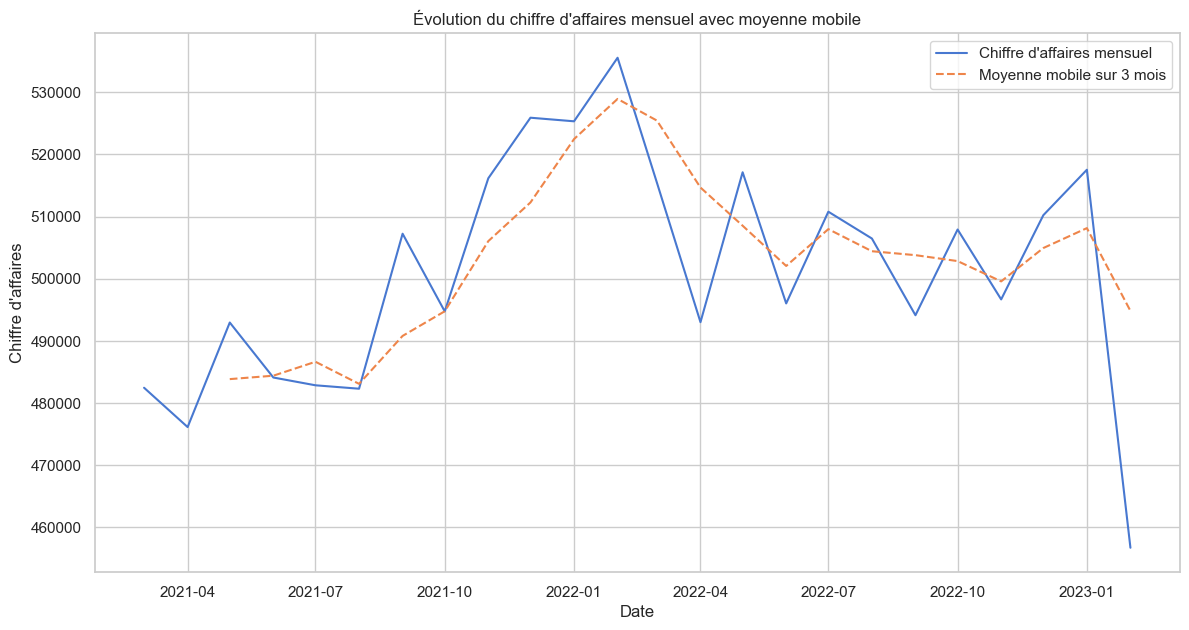

In [ ]:
# Calculer le chiffre d'affaires par mois
monthly_revenue = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['price'].sum()

# Convertir l'index pour un affichage correct
monthly_revenue.index = monthly_revenue.index.to_timestamp()

# Calculer la moyenne mobile sur 3 mois (par exemple)
monthly_revenue_moving_avg = monthly_revenue.rolling(window=3).mean()

# Tracer le graphique
plt.figure(figsize=(14, 7))
plt.plot(monthly_revenue.index, monthly_revenue, label="Chiffre d'affaires mensuel")
plt.plot(monthly_revenue.index, monthly_revenue_moving_avg, label='Moyenne mobile sur 3 mois', linestyle='--')
plt.title("Évolution du chiffre d'affaires mensuel avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

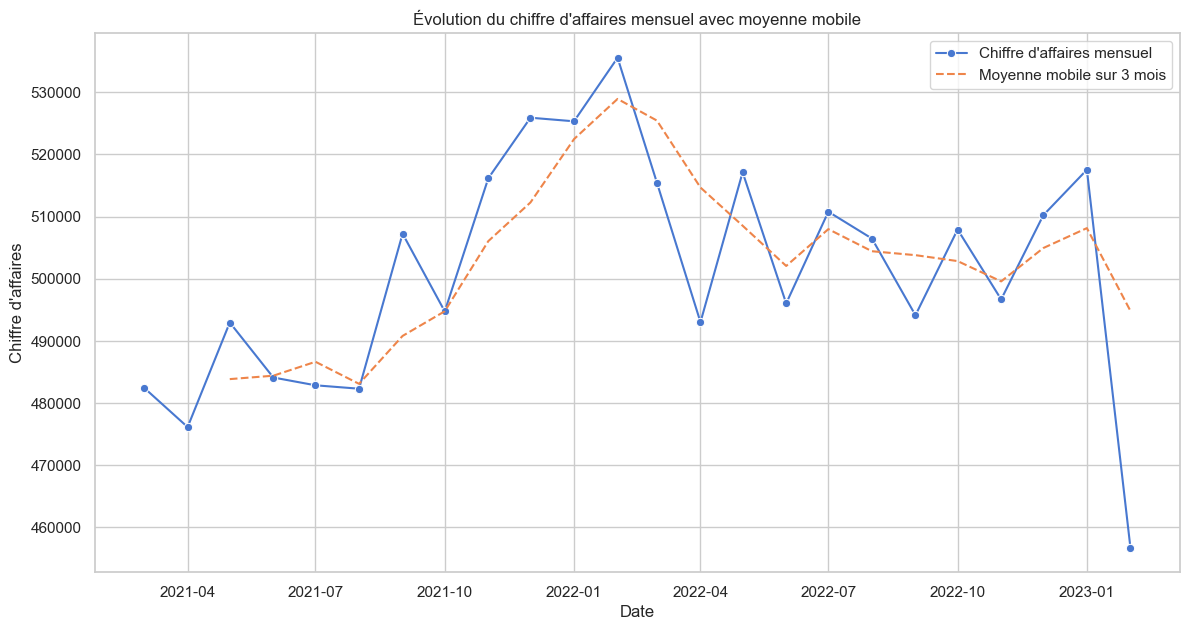

In [ ]:
# Tracer le graphique avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue, label="Chiffre d'affaires mensuel", marker='o')
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue_moving_avg, label='Moyenne mobile sur 3 mois', linestyle='--')
plt.title("Évolution du chiffre d'affaires mensuel avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def gini_coefficient(x):
    # Trier les valeurs
    sorted_x = np.sort(x)
    n = len(x)
    
    # Calculer l'indice de Gini en suivant la formule
    cumulative_sum = np.cumsum(sorted_x) 
    gini_index = (2 / n) * np.sum((np.arange(1, n+1)) * sorted_x) / cumulative_sum[-1] - (n + 1) / n
    
    return gini_index


In [ ]:

# Exemple : Calcul de l'indice de Gini pour le CA par client
revenue_per_client = df_transactions_products.groupby('client_id')['price'].sum()
gini_index = gini_coefficient(revenue_per_client.values)

print(f"Indice de Gini pour le CA par client: {gini_index}")

Indice de Gini pour le CA par client: 0.4418958799561552


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2 - Chiffre d'affaires par catégorie</h3>
</div>

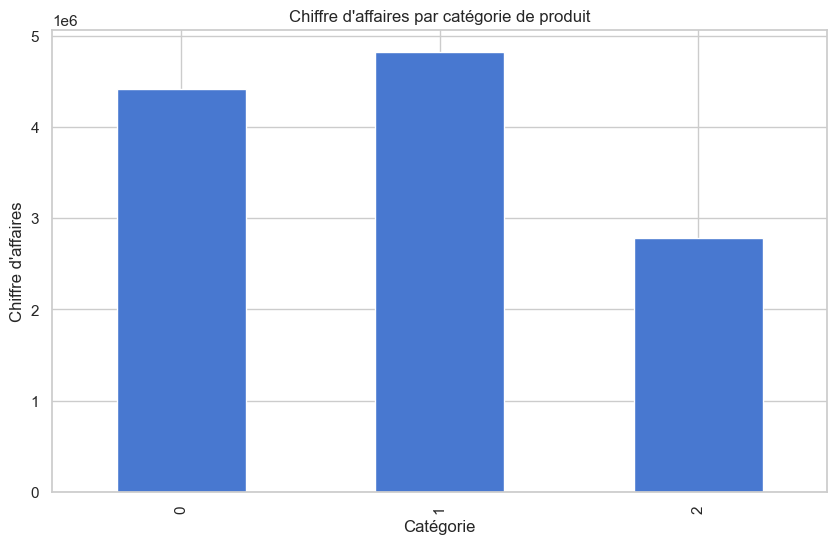

In [ ]:
# Calculer le chiffre d'affaires par catégorie de produit
revenue_by_category = df_transactions_products.groupby('categ')['price'].sum()

# Tracer le graphique
plt.figure(figsize=(10, 6))
revenue_by_category.plot(kind='bar')
plt.title("Chiffre d'affaires par catégorie de produit")
plt.xlabel("Catégorie")
plt.ylabel("Chiffre d'affaires")
plt.grid(True)
plt.show()


In [ ]:
df_transactions_products

,id_prod,date,session_id,client_id,format_check,price,categ
0,0_0,2021-03-01 13:45:51.575117,s_282,c_5152,Valid,3.75,0
1,0_0,2021-03-02 06:42:55.351333,s_621,c_2917,Valid,3.75,0
2,0_0,2021-03-02 18:49:49.651862,s_852,c_3988,Valid,3.75,0
3,0_0,2021-03-02 21:57:33.862118,s_908,c_1004,Valid,3.75,0
4,0_0,2021-03-03 23:59:48.997483,s_1379,c_278,Valid,3.75,0
...,...,...,...,...,...,...,...
687550,2_99,2022-05-21 01:53:46.967570,s_211661,c_5828,Valid,84.99,2
687551,2_99,2022-07-21 01:53:46.967570,s_241374,c_5828,Valid,84.99,2
687552,2_99,2022-11-11 20:56:49.820935,s_296127,c_7135,Valid,84.99,2
687553,2_99,2022-12-11 20:56:49.820935,s_310606,c_7135,Valid,84.99,2


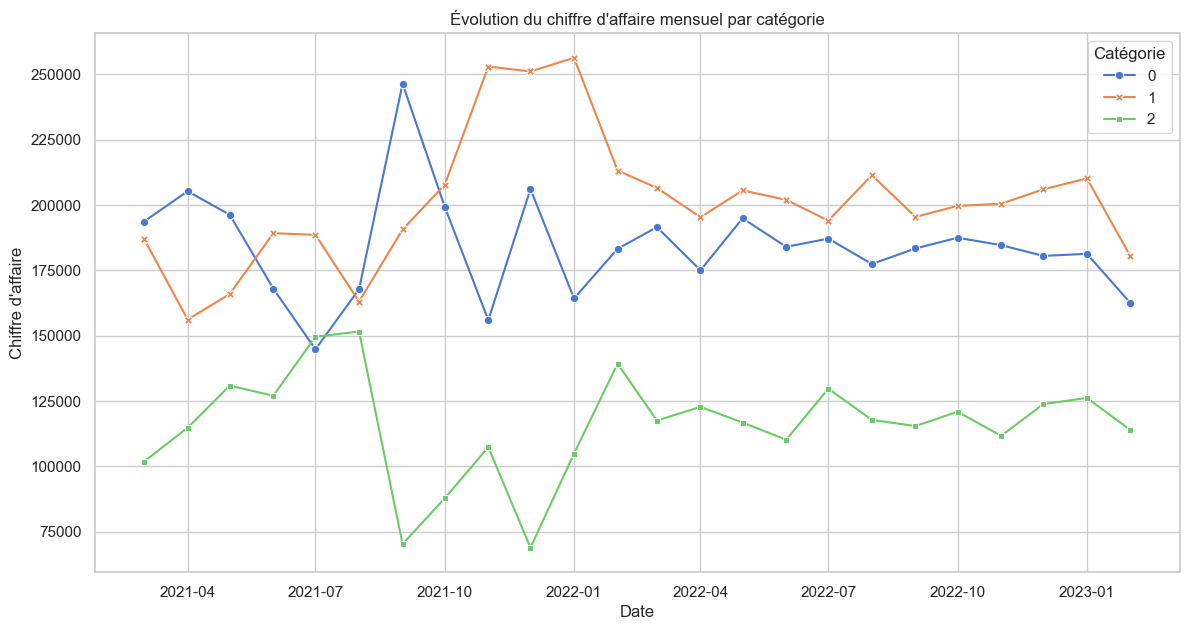

In [ ]:
# Calculer le chiffre d'affaires par mois et par catégorie
monthly_revenue_by_category = df_transactions_products.groupby([df_transactions_products['date'].dt.to_period("M"), 'categ'])['price'].sum().unstack()

# Convertir l'index pour un affichage correct
monthly_revenue_by_category.index = monthly_revenue_by_category.index.to_timestamp()

# Tracer les graphiques avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_revenue_by_category, markers=True, dashes=False)

# Personnalisation du graphique
plt.title("Évolution du chiffre d'affaire mensuel par catégorie")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaire")
plt.legend(title='Catégorie')
plt.grid(True)
plt.show()


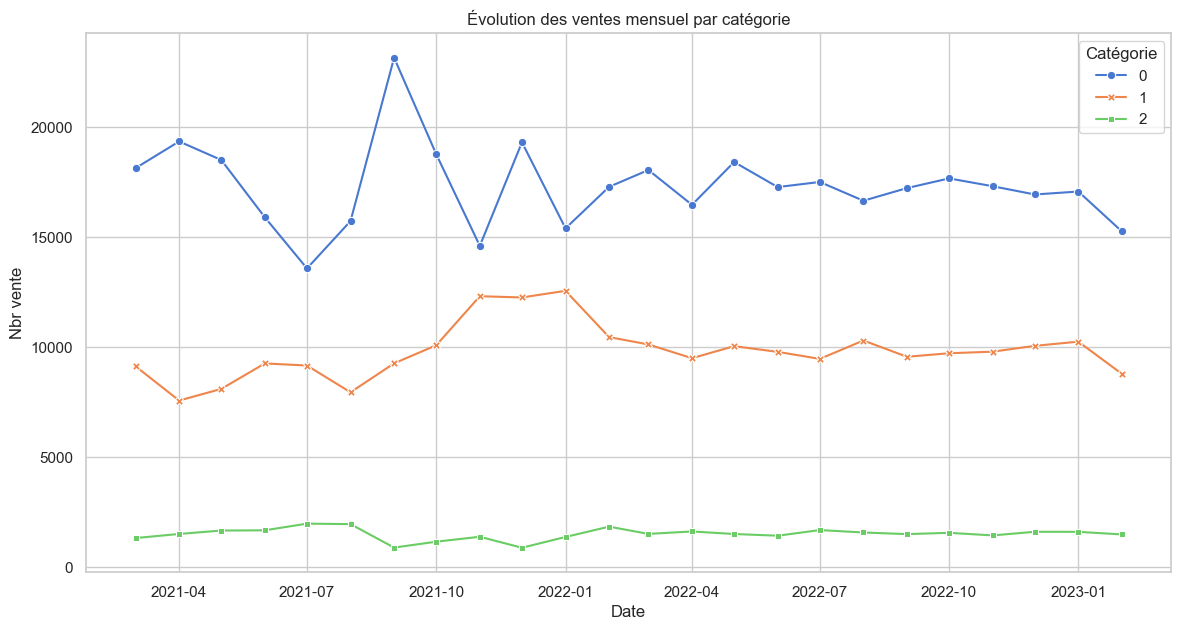

In [ ]:
# Calculer le nombre de ventes par mois et par catégorie
monthly_sold_by_category = df_transactions_products.groupby([df_transactions_products['date'].dt.to_period("M"), 'categ'])['price'].count().unstack()

# Convertir l'index pour un affichage correct
monthly_sold_by_category.index = monthly_sold_by_category.index.to_timestamp()

# Tracer les graphiques avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sold_by_category, markers=True, dashes=False)

# Personnalisation du graphique
plt.title("Évolution des ventes mensuel par catégorie")
plt.xlabel("Date")
plt.ylabel("Nbr vente")
plt.legend(title='Catégorie')
plt.grid(True)
plt.show()

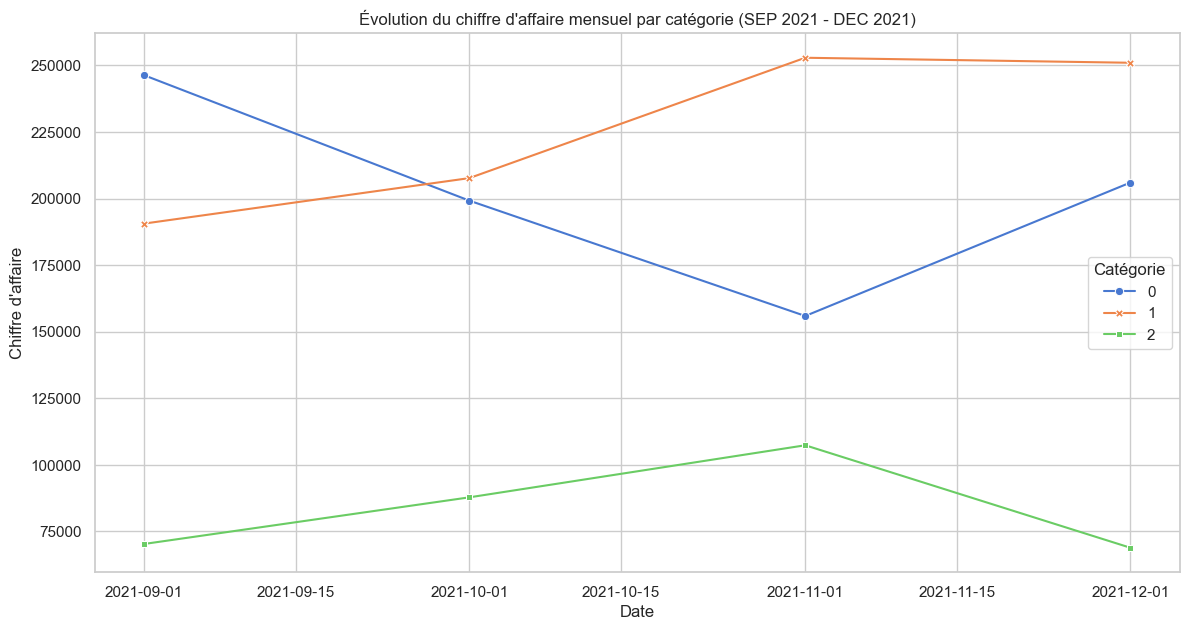

In [ ]:
# Filtrer les données entre 2021-10 et 2021-11
filtered_data_r = monthly_revenue_by_category.loc['2021-09':'2021-12']

# Tracer les graphiques avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=filtered_data_r, markers=True, dashes=False)

# Personnalisation du graphique
plt.title("Évolution du chiffre d'affaire mensuel par catégorie (SEP 2021 - DEC 2021)")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaire")
plt.legend(title='Catégorie')
plt.grid(True)
plt.show()

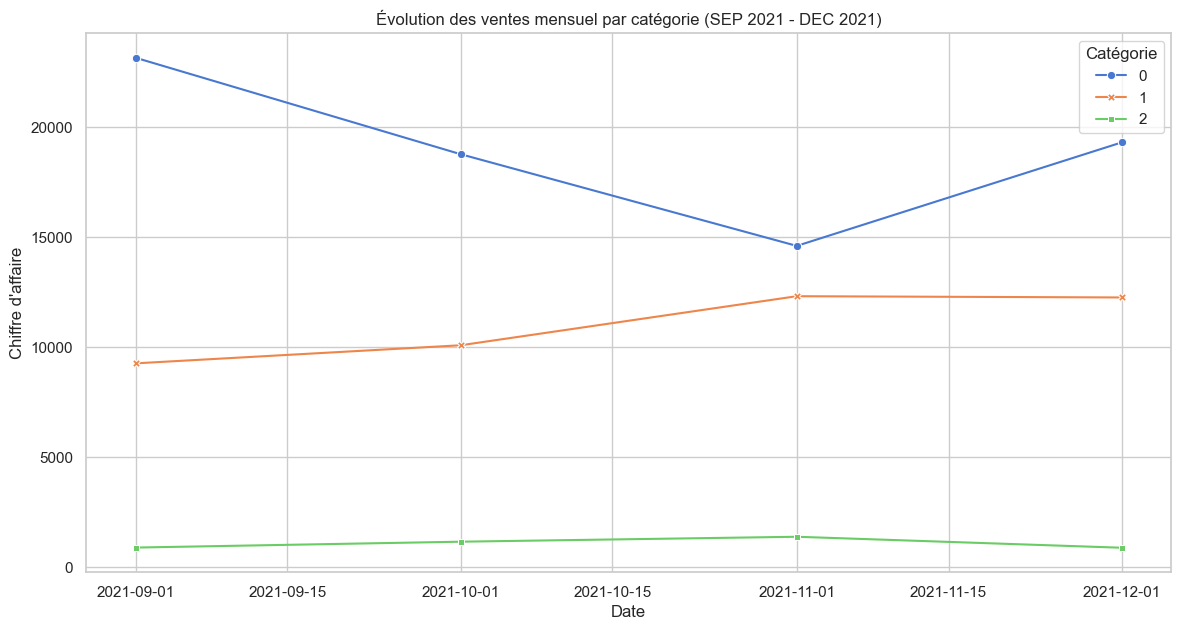

In [ ]:
# Filtrer les données entre 2021-10 et 2021-11
filtered_data_s = monthly_sold_by_category.loc['2021-09':'2021-12']

# Tracer les graphiques avec Seaborn
plt.figure(figsize=(14, 7))
sns.lineplot(data=filtered_data_s, markers=True, dashes=False)

# Personnalisation du graphique
plt.title("Évolution des ventes mensuel par catégorie (SEP 2021 - DEC 2021)")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaire")
plt.legend(title='Catégorie')
plt.grid(True)
plt.show()

In [ ]:
# Exclure le mois d'octobre 2021
df_transactions_products = df_transactions_products[~((df_transactions_products['date'] >= '2021-10-01') & (df_transactions_products['date'] < '2021-11-01'))]

# S'assurer que la colonne 'date' est bien en index
df_transactions_products.set_index('date', inplace=True)


In [ ]:

# Calculer le chiffre d'affaires par jour et ajouter une moyenne mobile
daily_revenue = df_transactions_products.groupby(df_transactions_products.index.date)['price'].sum()
daily_revenue = daily_revenue.to_frame(name='daily_revenue')
daily_revenue['7d_moving_avg'] = daily_revenue['daily_revenue'].rolling(window=7).mean()

# Afficher le DataFrame daily_revenue
daily_revenue.head()



,daily_revenue,7d_moving_avg
2021-03-01,16565.22,NaN
2021-03-02,15486.45,NaN
2021-03-03,15198.69,NaN
2021-03-04,15196.07,NaN
2021-03-05,17471.37,NaN


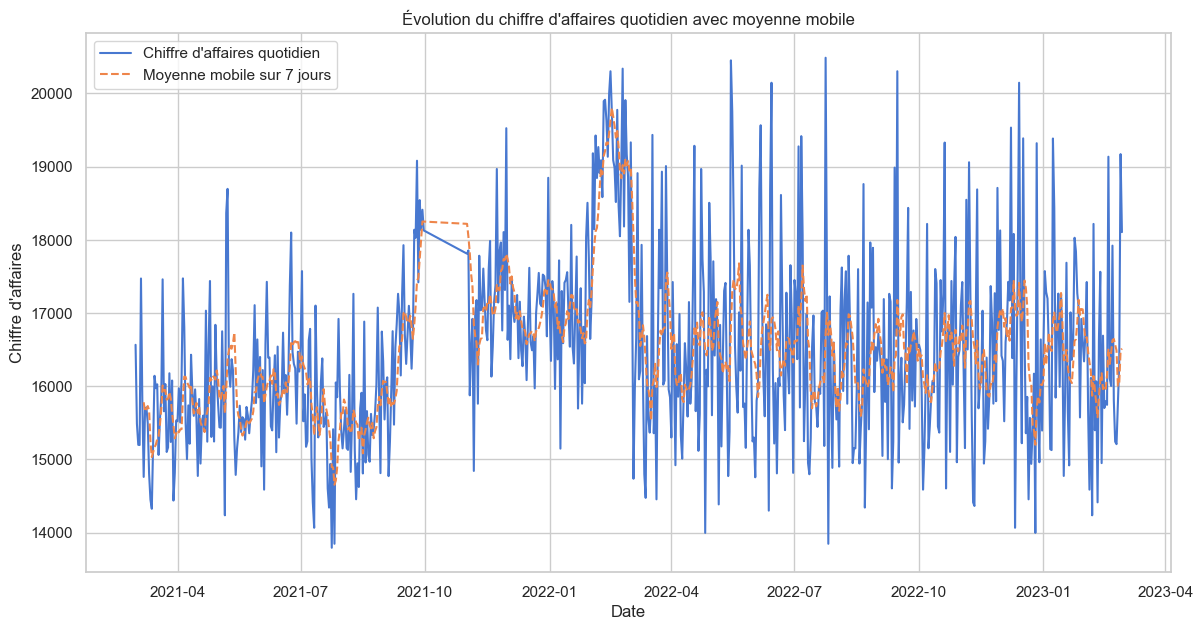

In [ ]:
#Palette de couleurs
sns.set_theme(style='whitegrid', palette='muted')

# Tracer le graphique
plt.figure(figsize=(14, 7))
plt.plot(daily_revenue.index, daily_revenue['daily_revenue'], label="Chiffre d'affaires quotidien")
plt.plot(daily_revenue.index, daily_revenue['7d_moving_avg'], label='Moyenne mobile sur 7 jours', linestyle='--')
plt.title("Évolution du chiffre d'affaires quotidien avec moyenne mobile")
plt.xlabel("Date")
plt.ylabel("Chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.3 - Nombre de clients par mois</h3>
</div>

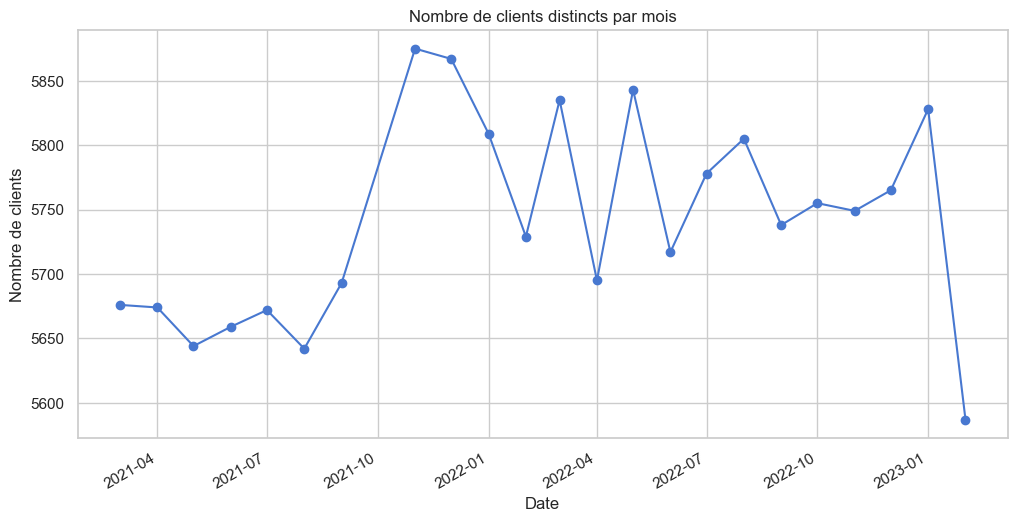

In [ ]:
df_transactions_products.reset_index(inplace=True)
# Calculer le nombre de clients distincts par mois
clients_per_month = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['client_id'].nunique()

# Convertir l'index pour un affichage correct
clients_per_month.index = clients_per_month.index.to_timestamp()

# Tracer le graphique
plt.figure(figsize=(12, 6))
clients_per_month.plot(kind='line', marker='o')
plt.title("Nombre de clients distincts par mois")
plt.xlabel("Date")
plt.ylabel("Nombre de clients")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.4 - Nombre de transactions par mois</h3>
</div>

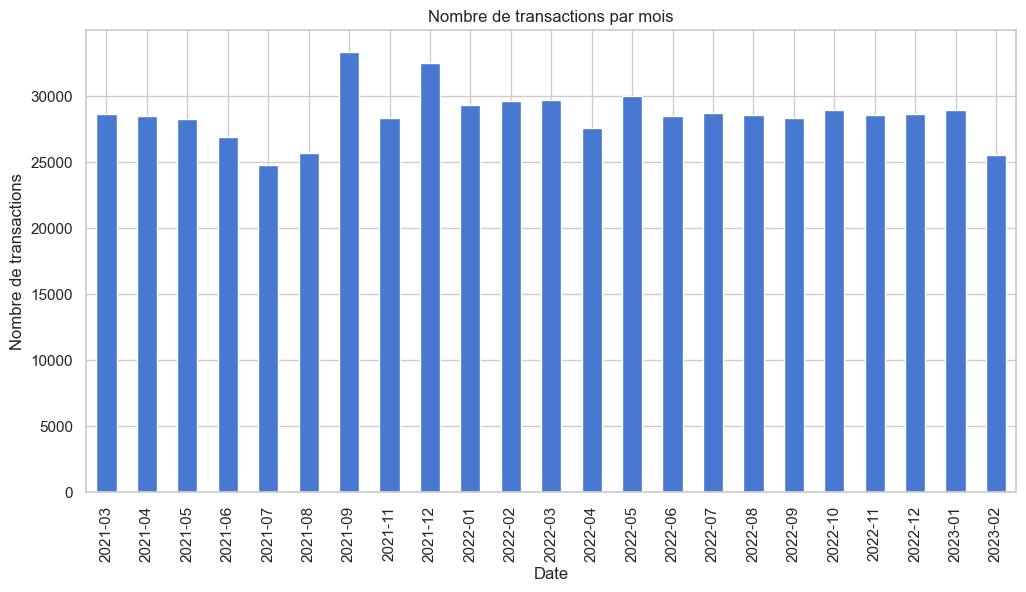

In [ ]:
# Calculer le nombre de transactions par mois
transactions_per_month = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['session_id'].count()


# Tracer le graphique
plt.figure(figsize=(12, 6))
transactions_per_month.plot(kind='bar')
plt.title("Nombre de transactions par mois")
plt.xlabel("Date")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.5 - Nombre de produits vendus par mois</h3>
</div>

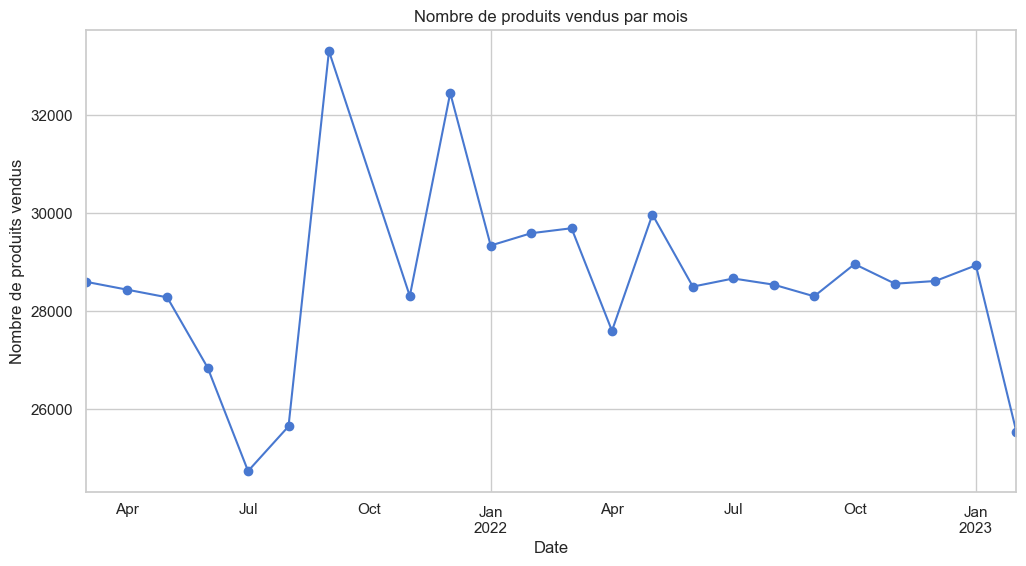

In [ ]:
# Calculer le nombre de produits vendus par mois
products_sold_per_month = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['id_prod'].count()

# Tracer le graphique
plt.figure(figsize=(12, 6))
products_sold_per_month.plot(kind='line', marker='o')
plt.title("Nombre de produits vendus par mois")
plt.xlabel("Date")
plt.ylabel("Nombre de produits vendus")
plt.grid(True)
plt.show()


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">4 - Zoom sur les références</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.1 - Les Tops (produits les plus vendus)</h3>
</div>

In [ ]:
# Identifier les 10 produits les plus vendus
top_products = df_transactions_products['id_prod'].value_counts().head(10)

# Afficher les résultats
print(top_products)


id_prod
1_369    2237
1_417    2173
1_414    2166
1_498    2117
1_425    2084
1_403    1950
1_412    1938
1_413    1931
1_406    1931
1_407    1923
Name: count, dtype: int64


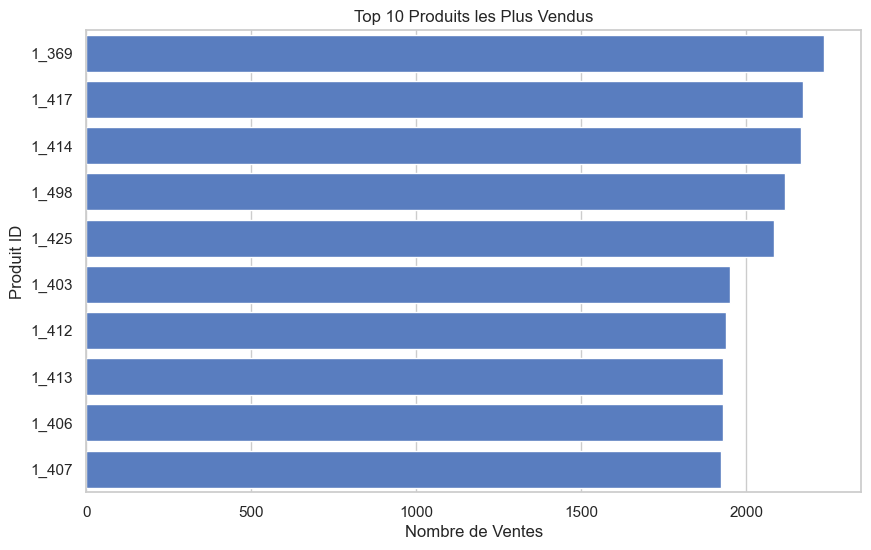

In [ ]:
# Créer un graphique en barres
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Produits les Plus Vendus")
plt.xlabel("Nombre de Ventes")
plt.ylabel("Produit ID")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.2 - Les Flops (produits les moins vendus)</h3>
</div>

In [ ]:
# Compter le nombre d'achats par client
client_purchase_counts = df_transactions_products['client_id'].value_counts()

# Filtrer les clients avec un seul achat
single_purchase_clients = client_purchase_counts[client_purchase_counts == 1].index

# Extraire les transactions pour ces clients
flop_products = df_transactions_products[df_transactions_products['client_id'].isin(single_purchase_clients)]

In [ ]:
client_purchase_counts.tail(10)

client_id
c_4223    1
c_1828    1
c_6292    1
c_2793    1
c_4648    1
c_1624    1
c_6879    1
c_5962    1
c_4478    1
c_240     1
Name: count, dtype: int64

In [ ]:
flop = flop_products['categ'].value_counts()
flop

categ
1    8
2    3
0    1
Name: count, dtype: int64

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_14132\3543504891.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flop.index, y=flop.values, palette='muted')


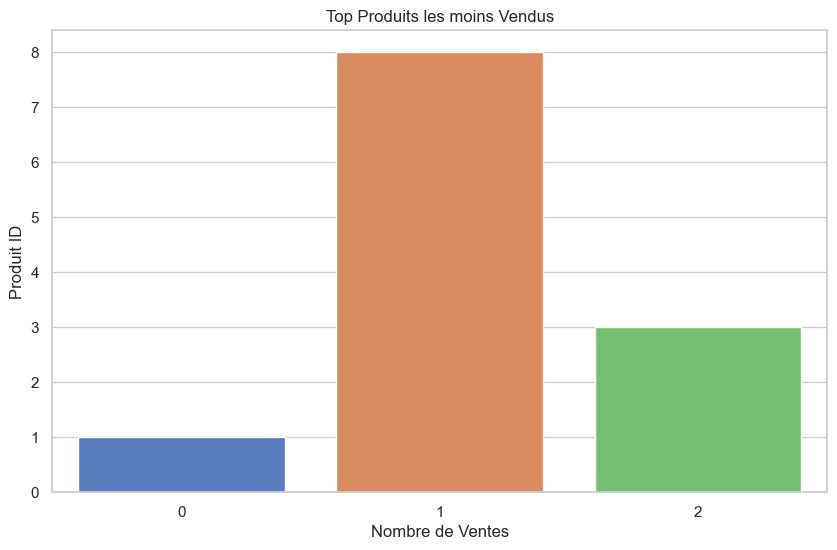

In [ ]:
# Définir les couleurs en fonction des catégories
colors = ['blue', 'orange', 'green']

# Créer un graphique en barres
plt.figure(figsize=(10, 6))
sns.barplot(x=flop.index, y=flop.values, palette='muted')
plt.title("Top Produits les moins Vendus")
plt.xlabel("Nombre de Ventes")
plt.ylabel("Produit ID")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.3 - Répartition par catégorie</h3>
</div>

In [ ]:
df_transactions_products

,date,id_prod,session_id,client_id,format_check,price,categ
0,2021-03-01 13:45:51.575117,0_0,s_282,c_5152,Valid,3.75,0
1,2021-03-02 06:42:55.351333,0_0,s_621,c_2917,Valid,3.75,0
2,2021-03-02 18:49:49.651862,0_0,s_852,c_3988,Valid,3.75,0
3,2021-03-02 21:57:33.862118,0_0,s_908,c_1004,Valid,3.75,0
4,2021-03-03 23:59:48.997483,0_0,s_1379,c_278,Valid,3.75,0
...,...,...,...,...,...,...,...
657507,2022-05-21 01:53:46.967570,2_99,s_211661,c_5828,Valid,84.99,2
657508,2022-07-21 01:53:46.967570,2_99,s_241374,c_5828,Valid,84.99,2
657509,2022-11-11 20:56:49.820935,2_99,s_296127,c_7135,Valid,84.99,2
657510,2022-12-11 20:56:49.820935,2_99,s_310606,c_7135,Valid,84.99,2


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_14132\2818387572.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=ventes_by_category.index, y=ventes_by_category.values, palette='muted')


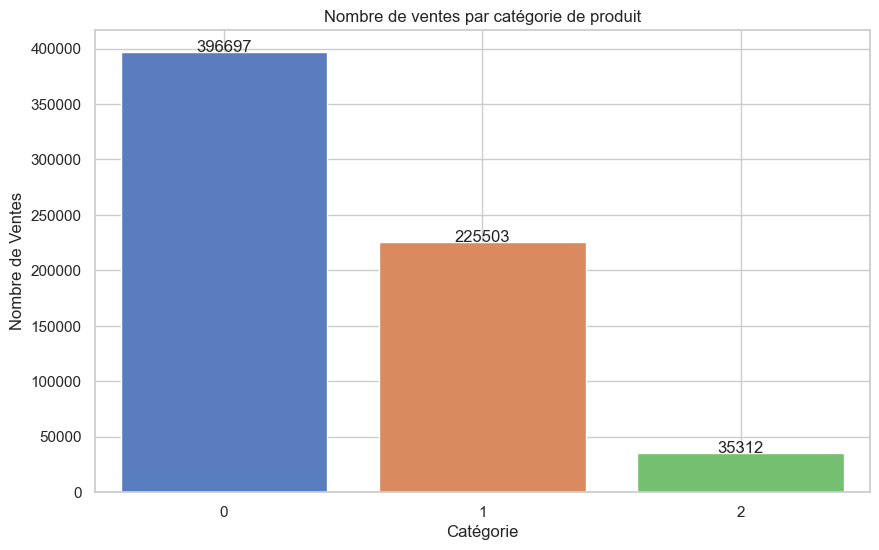

In [ ]:
# Calculer le chiffre d'affaires par catégorie de produit
ventes_by_category = df_transactions_products.groupby('categ')['price'].count()

# Définir les couleurs en fonction des catégories
colors = ['blue', 'orange', 'green']
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=ventes_by_category.index, y=ventes_by_category.values, palette='muted')

# Ajouter les valeurs sur les barres
for index, value in enumerate(ventes_by_category.values):
    plt.text(index, value + 0.05, f'{value}', ha='center')

# Définir le titre et les labels
plt.title("Nombre de ventes par catégorie de produit")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de Ventes")
plt.grid(True)
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.4 - Répartition du chiffre d'affaires pour les clients BtoB vs BtoC</h3>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.5 - Courbe de Lorenz</h3>
</div>

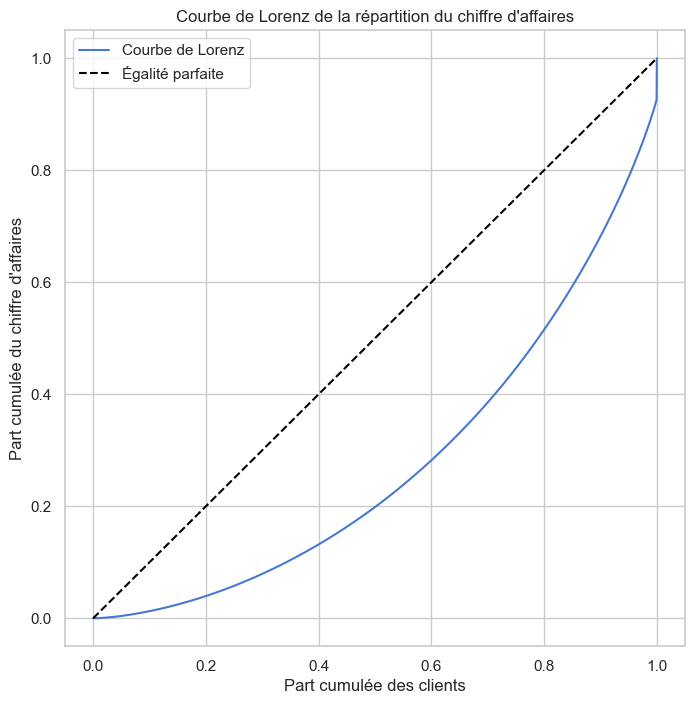

In [ ]:
# Calcul du chiffre d'affaires par client
revenue_per_client = df_transactions_products.groupby('client_id')['price'].sum()

# Calculer la courbe de Lorenz
sorted_revenue = np.sort(revenue_per_client)
cumulative_revenue = np.cumsum(sorted_revenue)
lorenz_curve = cumulative_revenue / cumulative_revenue[-1]
lorenz_curve = np.insert(lorenz_curve, 0, 0)  # Ajouter un point à l'origine

# Tracer la courbe de Lorenz
plt.figure(figsize=(8, 8))
plt.plot(np.linspace(0, 1, len(lorenz_curve)), lorenz_curve, label="Courbe de Lorenz")
plt.plot([0, 1], [0, 1], '--', color='black', label="Égalité parfaite")
plt.xlabel("Part cumulée des clients")
plt.ylabel("Part cumulée du chiffre d'affaires")
plt.title("Courbe de Lorenz de la répartition du chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">5 - Analyses complémentaires</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.1 - Évolution du panier moyen par mois</h3>
</div>

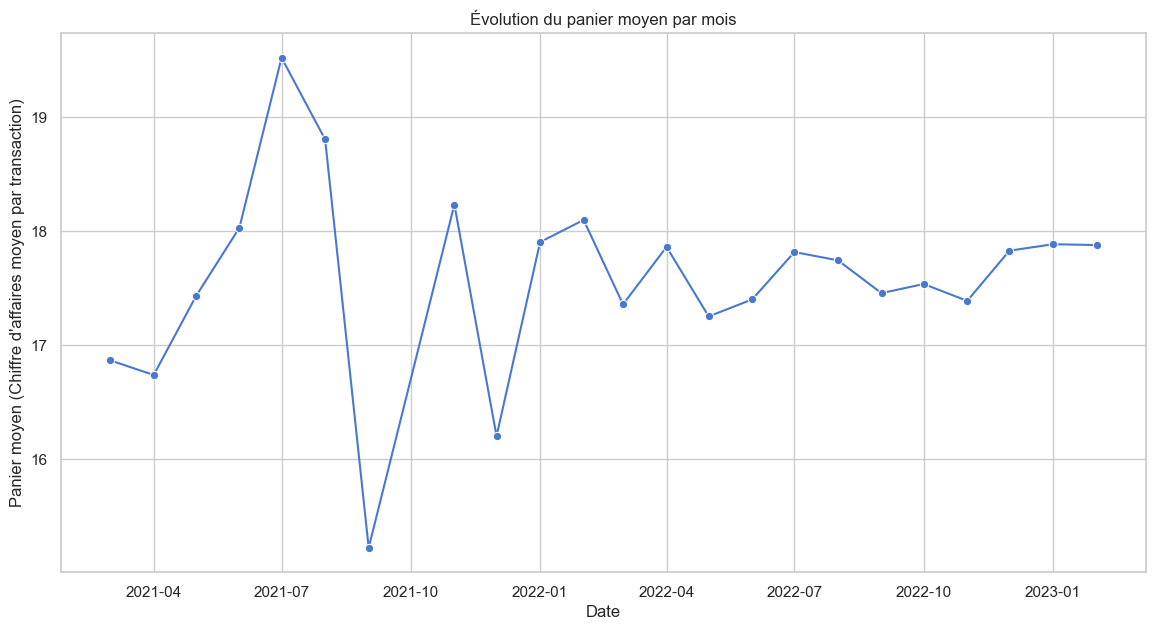

In [ ]:
df_transactions_products.reset_index(inplace=True)
# Calculer le chiffre d'affaires total par mois
monthly_revenue = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['price'].sum()

# Calculer le nombre de transactions par mois
monthly_transactions = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['session_id'].count()

# Calculer le panier moyen par mois
average_basket = monthly_revenue / monthly_transactions

# Tracer le graphique
plt.figure(figsize=(14, 7))
sns.lineplot(x=average_basket.index.to_timestamp(), y=average_basket, marker='o')
plt.title("Évolution du panier moyen par mois")
plt.xlabel("Date")
plt.ylabel("Panier moyen (Chiffre d'affaires moyen par transaction)")
plt.grid(True)
plt.show()


In [ ]:
monthly_revenue

date
2021-03    482440.61
2021-04    476109.30
2021-05    492943.47
2021-06    484088.56
2021-07    482835.40
2021-08    482284.79
2021-09    507240.68
2021-11    516167.73
2021-12    525917.28
2022-01    525338.99
2022-02    535571.50
2022-03    515456.53
2022-04    492998.94
2022-05    517132.60
2022-06    496016.12
2022-07    510783.12
2022-08    506467.27
2022-09    494114.53
2022-10    507917.77
2022-11    496664.94
2022-12    510219.50
2023-01    517540.55
2023-02    456679.76
Freq: M, Name: price, dtype: float64

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.3 - Analyse des clients fidèles - total achat</h3>
</div>

client_id
c_1609    24472
c_6714     8897
c_3454     6632
c_4958     5090
c_3263      392
c_2595      384
c_2140      381
c_2077      370
c_7319      368
c_7421      368
Name: count, dtype: int64


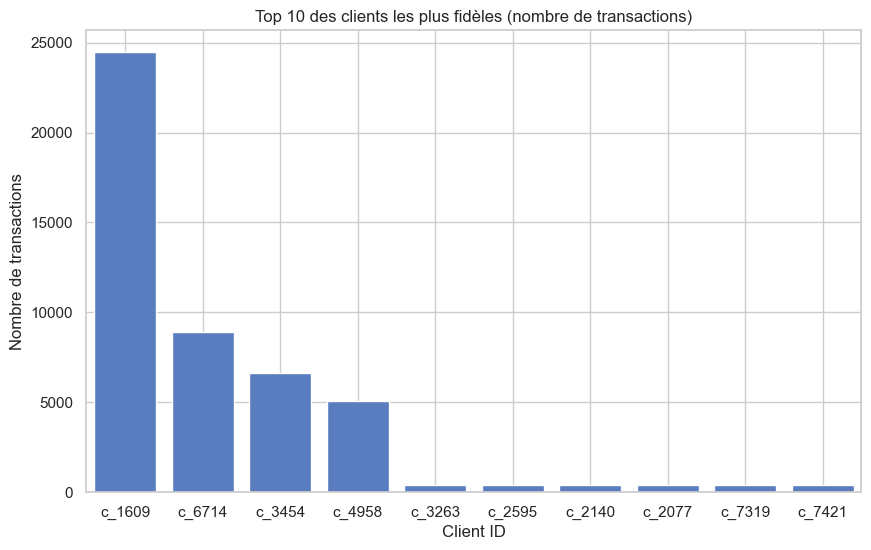

In [ ]:
# Calculer le nombre de transactions par client
transactions_per_client = df_transactions_products['client_id'].value_counts()

# Identifier les 10 clients les plus fidèles
top_loyal_customers = transactions_per_client.head(10)

# Afficher les résultats
print(top_loyal_customers)

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=top_loyal_customers.index, y=top_loyal_customers.values)
plt.title("Top 10 des clients les plus fidèles (nombre de transactions)")
plt.xlabel("Client ID")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()


client_id
c_1609    24472
c_6714     8897
c_3454     6632
c_4958     5090
c_3263      392
c_2595      384
c_2140      381
c_2077      370
c_7319      368
c_7421      368
Name: count, dtype: int64


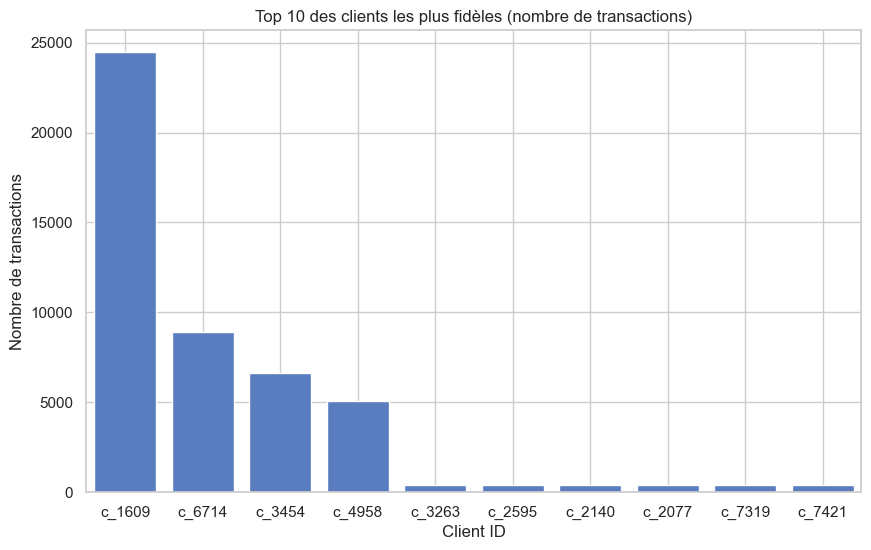

In [ ]:
# Calculer le nombre de transactions par client
transactions_per_client = df_transactions_products['client_id'].value_counts()

# Identifier les 10 clients les plus fidèles
top_loyal_customers = transactions_per_client.head(10)

# Afficher les résultats
print(top_loyal_customers)

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=top_loyal_customers.index, y=top_loyal_customers.values)
plt.title("Top 10 des clients les plus fidèles (nombre de transactions)")
plt.xlabel("Client ID")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">5.4 - Analyse des clients fidèles - total montant achat</h3>
</div>

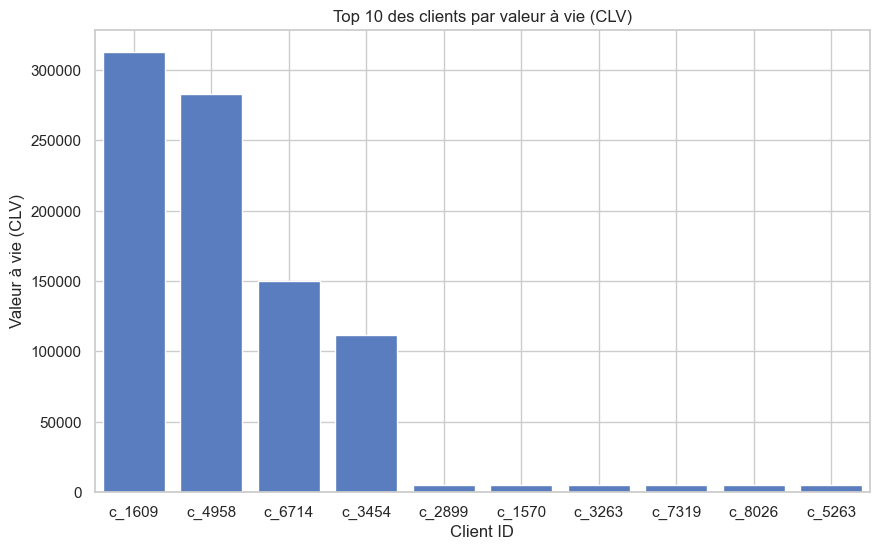

In [ ]:
# Calculer la CLV par client
clv = df_transactions_products.groupby('client_id')['price'].sum()

# Afficher les clients ayant la plus haute CLV
top_clv_customers = clv.sort_values(ascending=False).head(10)

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=top_clv_customers.index, y=top_clv_customers.values)
plt.title("Top 10 des clients par valeur à vie (CLV)")
plt.xlabel("Client ID")
plt.ylabel("Valeur à vie (CLV)")
plt.grid(True)
plt.show()


<div style="border: 1px solid RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6 - Separation BtoB_BtoC</h2>
</div>

In [ ]:
# Calculer la dépense totale de chaque client
total_spent_per_client = df_transactions_products.groupby('client_id')['price'].sum()

# Calculer la dépense moyenne de tous les clients
average_spent_all_clients = total_spent_per_client.mean()

# Trouver les clients qui dépensent 20 fois plus que la moyenne des autres clients
high_spenders = total_spent_per_client[total_spent_per_client > (average_spent_all_clients * 20)]

# Afficher les résultats
print("Clients qui dépensent 20 fois plus que la moyenne des autres clients :")
print(high_spenders)

Clients qui dépensent 20 fois plus que la moyenne des autres clients :
client_id
c_1609    312755.08
c_3454    111766.71
c_4958    282654.61
c_6714    149783.75
Name: price, dtype: float64


In [ ]:
# Étape 1: Identifier les `BtoC` des "BtoB"
high_spender_ids = high_spenders.index

In [ ]:

# Étape 2: Créer un DataFrame pour les "high spenders"
df_btob = df_transactions_products[df_transactions_products['client_id'].isin(high_spender_ids)]

# Étape 3: Créer un DataFrame pour les autres clients (exclure les "high spenders")
df_btoc = df_transactions_products[~df_transactions_products['client_id'].isin(high_spender_ids)]

# Afficher les deux DataFrames pour vérification
print("DataFrame des BtoB:")
print(df_btob.head())

print("\nDataFrame des BtoC:")
print(df_btoc.head())

DataFrame des BtoB:
    index                       date id_prod session_id client_id  \
7       7 2021-03-10 06:43:31.234015     0_0     s_4266    c_6714   
9       9 2021-03-10 15:40:09.343729     0_0     s_4428    c_6714   
31     31 2021-03-22 23:37:09.874830     0_0    s_10114    c_1609   
54     54 2021-04-08 15:29:10.605154     0_0    s_17758    c_1609   
79     79 2021-04-17 20:09:37.561114     0_0    s_21987    c_1609   

   format_check  price  categ  
7         Valid   3.75      0  
9         Valid   3.75      0  
31        Valid   3.75      0  
54        Valid   3.75      0  
79        Valid   3.75      0  

DataFrame des BtoC:
   index                       date id_prod session_id client_id format_check  \
0      0 2021-03-01 13:45:51.575117     0_0      s_282    c_5152        Valid   
1      1 2021-03-02 06:42:55.351333     0_0      s_621    c_2917        Valid   
2      2 2021-03-02 18:49:49.651862     0_0      s_852    c_3988        Valid   
3      3 2021-03-02 21:57:33

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.1 - Analyser BtoB</h3>
</div>

In [ ]:
# Revenue total pour les clients B2B
total_revenue_btob = df_btob['price'].sum()

# Nombre de clients distincts pour les clients B2B
num_clients_btob = df_btob['client_id'].nunique()

# Nombre total d'achats pour les clients B2B
total_purchases_btob = df_btob['client_id'].count()

# Nombre moyen d'achats par client pour les clients B2B
avg_purchases_per_client_btob = total_purchases_btob / num_clients_btob if num_clients_btob else 0

# Valeur moyenne des achats pour les clients B2B
avg_order_value_btob = df_btob['price'].mean()

# CLV simplifié pour les clients B2B (somme des dépenses par client)
clv_simplified_btob = df_btob.groupby('client_id')['price'].sum().mean()

print("KPI pour les clients B2B :")
print(f"Total Revenue: {total_revenue_btob:.2f}")
print(f"Number of Clients: {num_clients_btob:.2f}")
print(f"Total Purchases: {total_purchases_btob:.2f}")
print(f"Average Purchases per Client: {avg_purchases_per_client_btob:.2f}")
print(f"Average Order Value: {avg_order_value_btob:.2f}")
print(f"Simplified CLV: {clv_simplified_btob:.2f}")

KPI pour les clients B2B :
Total Revenue: 856960.15
Number of Clients: 4.00
Total Purchases: 45091.00
Average Purchases per Client: 11272.75
Average Order Value: 19.01
Simplified CLV: 214240.04


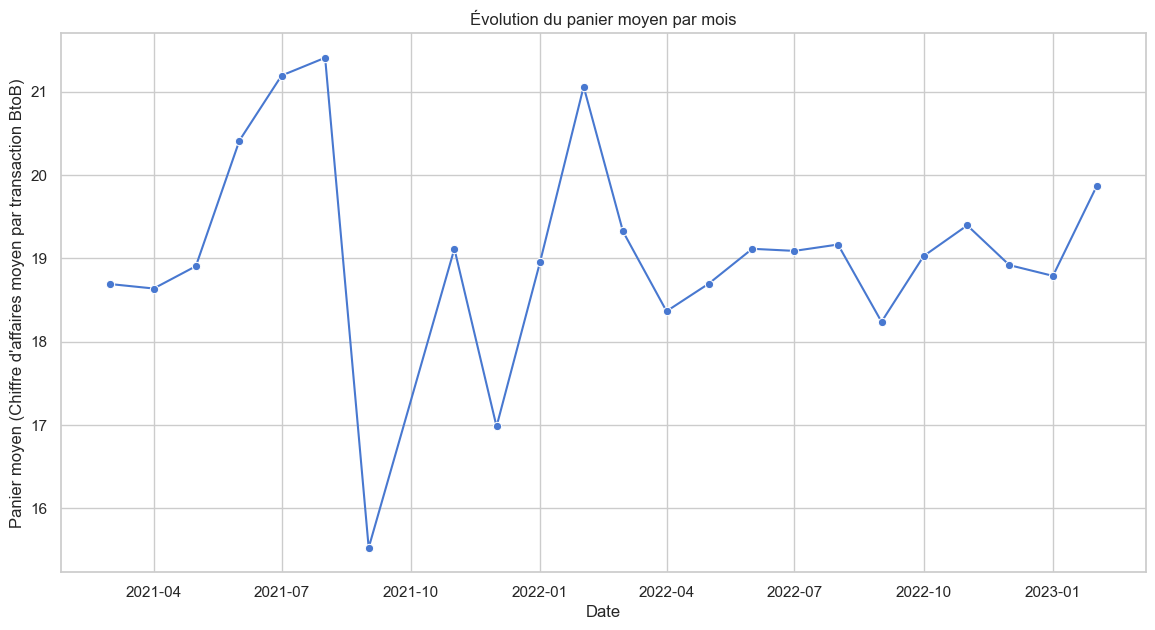

In [ ]:
# Calculer le chiffre d'affaires total par mois
monthly_revenue_btob = df_btob.groupby(df_btob['date'].dt.to_period("M"))['price'].sum()

# Calculer le nombre de transactions par mois
monthly_transactions_btob = df_btob.groupby(df_btob['date'].dt.to_period("M"))['session_id'].count()

# Calculer le panier moyen par mois
average_basket_btob = monthly_revenue_btob / monthly_transactions_btob

# Tracer le graphique
plt.figure(figsize=(14, 7))
sns.lineplot(x=average_basket_btob.index.to_timestamp(), y=average_basket_btob, marker='o')
plt.title("Évolution du panier moyen par mois")
plt.xlabel("Date")
plt.ylabel("Panier moyen (Chiffre d'affaires moyen par transaction BtoB)")
plt.grid(True)
plt.show()

In [ ]:
# Exemple : Calcul de l'indice de Gini pour le CA par client
ca_df_btob = df_btob.groupby('client_id')['price'].sum()
gini_index_ca_btob = gini_coefficient(ca_df_btob.values)

print(f"Indice de Gini, CA generé par chaque client BtoB: {gini_index_ca_btob}")

Indice de Gini, CA generé par chaque client BtoB: 0.21466458212788586


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.2 - Analyser BtoC</h3>
</div>

In [ ]:
# Revenue total pour les clients B2C
total_revenue_btoc = df_btoc['price'].sum()

# Nombre de clients distincts pour les clients B2C
num_clients_btoc = df_btoc['client_id'].nunique()

# Nombre total d'achats pour les clients B2C
total_purchases_btoc = df_btoc['client_id'].count()

# Nombre moyen d'achats par client pour les clients B2C
avg_purchases_per_client_btoc = total_purchases_btoc / num_clients_btoc if num_clients_btoc else 0

# Valeur moyenne des achats pour les clients B2C
avg_order_value_btoc = df_btoc['price'].mean()

# CLV simplifié pour les clients B2C (somme des dépenses par client)
clv_simplified_btoc = df_btoc.groupby('client_id')['price'].sum().mean()

print("\nKPI pour les clients B2C :")
print(f"Total Revenue: {total_revenue_btoc:.2f}")
print(f"Number of Clients: {num_clients_btoc:.2f}")
print(f"Total Purchases: {total_purchases_btoc:.2f}")
print(f"Average Purchases per Client: {avg_purchases_per_client_btoc:.2f}")
print(f"Average Order Value: {avg_order_value_btoc:.2f}")
print(f"Simplified CLV: {clv_simplified_btoc:.2f}")


KPI pour les clients B2C :
Total Revenue: 10675969.79
Number of Clients: 8594.00
Total Purchases: 612421.00
Average Purchases per Client: 71.26
Average Order Value: 17.43
Simplified CLV: 1242.26


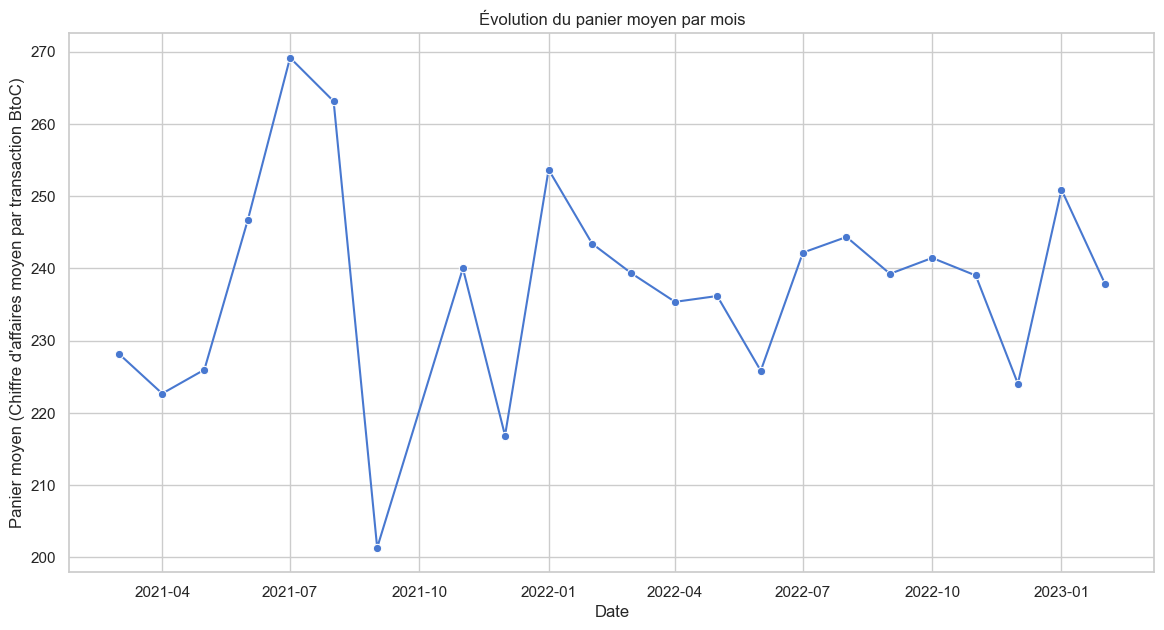

In [ ]:
# Calculer le chiffre d'affaires total par mois
monthly_revenue_btoc = df_btoc.groupby(df_btoc['date'].dt.to_period("M"))['price'].sum()

# Calculer le nombre de transactions par mois
monthly_transactions_btoc = df_btoc.groupby(df_btob['date'].dt.to_period("M"))['session_id'].count()

# Calculer le panier moyen par mois
average_basket_btoc = monthly_revenue_btoc / monthly_transactions_btob

# Tracer le graphique
plt.figure(figsize=(14, 7))
sns.lineplot(x=average_basket_btoc.index.to_timestamp(), y=average_basket_btoc, marker='o')
plt.title("Évolution du panier moyen par mois")
plt.xlabel("Date")
plt.ylabel("Panier moyen (Chiffre d'affaires moyen par transaction BtoC)")
plt.grid(True)
plt.show()

In [ ]:
# Calculer le total général pour chaque KPI
total_clients = num_clients_btob + num_clients_btoc
total_revenue = total_revenue_btob + total_revenue_btoc
total_purchases = total_purchases_btob + total_purchases_btoc
# Calculer les pourcentages
percentage_clients_btob = (num_clients_btob / total_clients) * 100
percentage_clients_btoc = (num_clients_btoc / total_clients) * 100

percentage_revenue_btob = (total_revenue_btob / total_revenue) * 100
percentage_revenue_btoc = (total_revenue_btoc / total_revenue) * 100

percentage_purchases_btob = (total_purchases_btob / total_purchases) * 100
percentage_purchases_btoc = (total_purchases_btoc / total_purchases) * 100

# Afficher les KPI en pourcentage
print("KPI en pourcentage pour B2B et B2C :\n")

print(f"Pourcentage de clients B2B : {percentage_clients_btob:.2f}%")
print(f"Pourcentage de clients B2C : {percentage_clients_btoc:.2f}%\n")

print(f"Pourcentage de revenu total B2B : {percentage_revenue_btob:.2f}%")
print(f"Pourcentage de revenu total B2C : {percentage_revenue_btoc:.2f}%\n")

print(f"Pourcentage du nombre total d'achats B2B : {percentage_purchases_btob:.2f}%")
print(f"Pourcentage du nombre total d'achats B2C : {percentage_purchases_btoc:.2f}%")

KPI en pourcentage pour B2B et B2C :

Pourcentage de clients B2B : 0.05%
Pourcentage de clients B2C : 99.95%

Pourcentage de revenu total B2B : 7.43%
Pourcentage de revenu total B2C : 92.57%

Pourcentage du nombre total d'achats B2B : 6.86%
Pourcentage du nombre total d'achats B2C : 93.14%


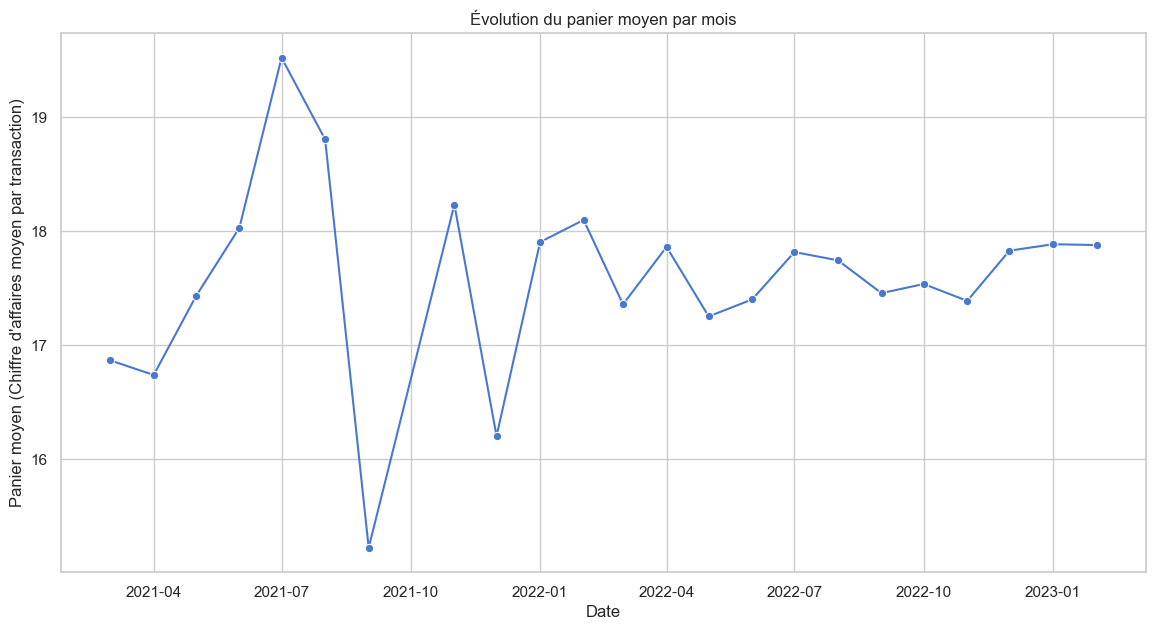

In [ ]:
# Calculer le chiffre d'affaires total par mois
monthly_revenue = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['price'].sum()

# Calculer le nombre de transactions par mois
monthly_transactions = df_transactions_products.groupby(df_transactions_products['date'].dt.to_period("M"))['session_id'].count()

# Calculer le panier moyen par mois
average_basket = monthly_revenue / monthly_transactions

# Tracer le graphique
plt.figure(figsize=(14, 7))
sns.lineplot(x=average_basket.index.to_timestamp(), y=average_basket, marker='o')
plt.title("Évolution du panier moyen par mois")
plt.xlabel("Date")
plt.ylabel("Panier moyen (Chiffre d'affaires moyen par transaction)")
plt.grid(True)
plt.show()

In [ ]:
# Exemple : Calcul de l'indice de Gini pour le CA par client
ca_df_btoc = df_btoc.groupby('client_id')['price'].sum()
gini_index_ca_btoc = gini_coefficient(ca_df_btoc.values)

print(f"Indice de Gini, CA generé par chaque client BtoC: {gini_index_ca_btoc}")

Indice de Gini, CA generé par chaque client BtoC: 0.4037231929152636


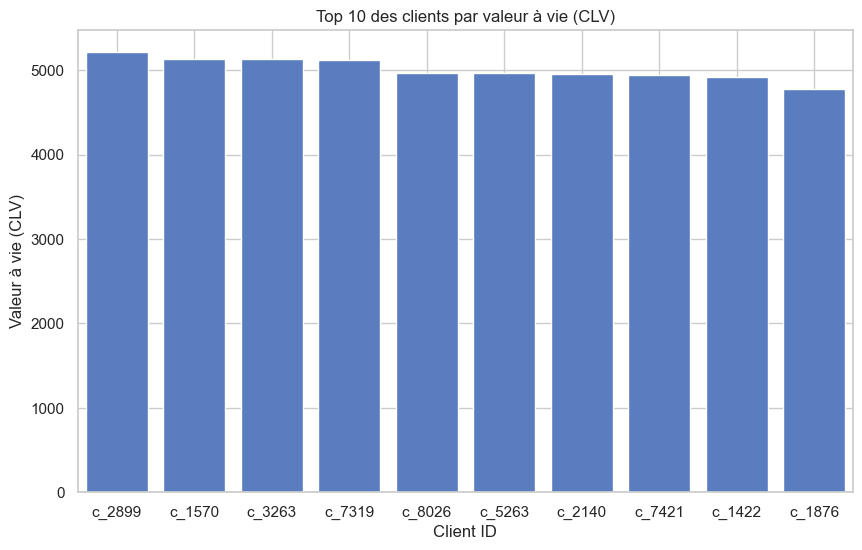

In [ ]:
# Calculer la CLV par client
clv_btoc = df_btoc.groupby('client_id')['price'].sum()

# Afficher les clients ayant la plus haute CLV
top_clv_btoc = clv_btoc.sort_values(ascending=False).head(10)

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=top_clv_btoc.index, y=top_clv_btoc.values)
plt.title("Top 10 des clients par valeur à vie (CLV)")
plt.xlabel("Client ID")
plt.ylabel("Valeur à vie (CLV)")
plt.grid(True)
plt.show()

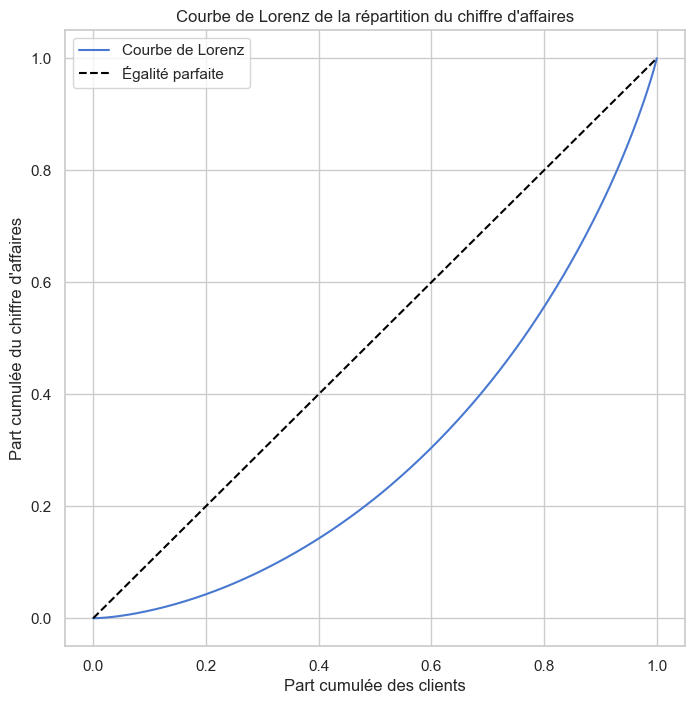

In [ ]:
# Calcul du chiffre d'affaires par client
ca_df_btoc

# Calculer la courbe de Lorenz
sorted_revenue_btoc = np.sort(ca_df_btoc)
cumulative_revenue_btoc = np.cumsum(sorted_revenue_btoc)
lorenz_curve_btoc = cumulative_revenue_btoc / cumulative_revenue_btoc[-1]
lorenz_curve_btoc = np.insert(lorenz_curve_btoc, 0, 0)  # Ajouter un point à l'origine

# Tracer la courbe de Lorenz
plt.figure(figsize=(8, 8))
plt.plot(np.linspace(0, 1, len(lorenz_curve_btoc)), lorenz_curve_btoc, label="Courbe de Lorenz")
plt.plot([0, 1], [0, 1], '--', color='black', label="Égalité parfaite")
plt.xlabel("Part cumulée des clients")
plt.ylabel("Part cumulée du chiffre d'affaires")
plt.title("Courbe de Lorenz de la répartition du chiffre d'affaires")
plt.legend()
plt.grid(True)
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.6 - Analyser l'Heure des Transactions</h3>
</div>

In [ ]:
df_merge_btob = df_btob.merge(df_customers,how='outer', on='client_id',indicator='_merge')
df_merge_btob

,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,_merge
0,NaT,NaN,NaN,c_1,NaN,NaN,NaN,m,69,right_only
1,NaT,NaN,NaN,c_10,NaN,NaN,NaN,m,68,right_only
2,NaT,NaN,NaN,c_100,NaN,NaN,NaN,m,32,right_only
3,NaT,NaN,NaN,c_1000,NaN,NaN,NaN,f,58,right_only
4,NaT,NaN,NaN,c_1001,NaN,NaN,NaN,m,42,right_only
...,...,...,...,...,...,...,...,...,...,...
53703,NaT,NaN,NaN,c_995,NaN,NaN,NaN,m,69,right_only
53704,NaT,NaN,NaN,c_996,NaN,NaN,NaN,f,54,right_only
53705,NaT,NaN,NaN,c_997,NaN,NaN,NaN,f,30,right_only
53706,NaT,NaN,NaN,c_998,NaN,NaN,NaN,m,23,right_only


In [ ]:
df_merge_btoc = df_btoc.merge(df_customers,how='outer', on='client_id',indicator='_merge')
df_merge_btoc

,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,_merge
0,2021-12-19 02:44:12.827475,0_1090,s_136532,c_1,Valid,13.78,0.0,m,69,both
1,2021-07-25 12:17:34.446678,0_1186,s_66947,c_1,Valid,12.30,0.0,m,69,both
2,2022-08-25 12:17:34.446678,0_1186,s_258252,c_1,Valid,12.30,0.0,m,69,both
3,2021-08-23 16:56:15.401655,0_1378,s_79696,c_1,Valid,13.96,0.0,m,69,both
4,2022-07-23 16:56:15.401655,0_1378,s_242617,c_1,Valid,13.96,0.0,m,69,both
...,...,...,...,...,...,...,...,...,...,...
612443,2022-01-19 09:10:14.900805,1_724,s_152063,c_999,Valid,16.94,1.0,m,60,both
612444,2021-11-21 17:40:50.856434,1_727,s_122996,c_999,Valid,16.99,1.0,m,60,both
612445,2022-05-21 17:40:50.856434,1_727,s_211960,c_999,Valid,16.99,1.0,m,60,both
612446,2022-07-21 17:40:50.856434,1_727,s_241673,c_999,Valid,16.99,1.0,m,60,both


In [ ]:
df_merge_btob[df_merge_btob['_merge']=='right_only']

,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,_merge
0,NaT,NaN,NaN,c_1,NaN,NaN,NaN,m,69,right_only
1,NaT,NaN,NaN,c_10,NaN,NaN,NaN,m,68,right_only
2,NaT,NaN,NaN,c_100,NaN,NaN,NaN,m,32,right_only
3,NaT,NaN,NaN,c_1000,NaN,NaN,NaN,f,58,right_only
4,NaT,NaN,NaN,c_1001,NaN,NaN,NaN,m,42,right_only
...,...,...,...,...,...,...,...,...,...,...
53703,NaT,NaN,NaN,c_995,NaN,NaN,NaN,m,69,right_only
53704,NaT,NaN,NaN,c_996,NaN,NaN,NaN,f,54,right_only
53705,NaT,NaN,NaN,c_997,NaN,NaN,NaN,f,30,right_only
53706,NaT,NaN,NaN,c_998,NaN,NaN,NaN,m,23,right_only


In [ ]:
df_merge_btob['_merge'].value_counts()

_merge
both          45091
right_only     8617
left_only         0
Name: count, dtype: int64

In [ ]:
# Calculer le pourcentage des données mises de côté dans le df BtoB
per_df_btob = (df_merge_btob['_merge'].value_counts()['right_only'] / df_merge_btob['_merge'].value_counts()['both']) * 100

print(f'Nous avons  {per_df_btob:.3f}% de données sans achat dont nous allons nous séparer pour le DF BtoB.')
# Clean (Pour l'instant on décide d'extraire ces données, en attendant la confirmation du client, cela va nous permettre de continuer notre analyse)
df_btob_nul = df_merge_btob[df_merge_btob["_merge"]=='right_only']
del df_btob_nul['_merge']
df_merge_btob = df_merge_btob[df_merge_btob["_merge"]=='both']
del df_merge_btob['_merge']

Nous avons  19.110% de données sans achat dont nous allons nous séparer pour le DF BtoB.


In [ ]:
df_merge_btoc[df_merge_btoc['_merge']=='right_only']

,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,_merge
17509,NaT,NaN,NaN,c_1223,NaN,NaN,NaN,m,61,right_only
48244,NaT,NaN,NaN,c_1609,NaN,NaN,NaN,m,44,right_only
135321,NaT,NaN,NaN,c_2706,NaN,NaN,NaN,f,57,right_only
158519,NaT,NaN,NaN,c_3017,NaN,NaN,NaN,f,32,right_only
181249,NaT,NaN,NaN,c_3308,NaN,NaN,NaN,f,33,right_only
191261,NaT,NaN,NaN,c_3443,NaN,NaN,NaN,m,65,right_only
192292,NaT,NaN,NaN,c_3454,NaN,NaN,NaN,m,55,right_only
198437,NaT,NaN,NaN,c_3526,NaN,NaN,NaN,m,68,right_only
218355,NaT,NaN,NaN,c_3789,NaN,NaN,NaN,f,27,right_only
238600,NaT,NaN,NaN,c_4086,NaN,NaN,NaN,f,32,right_only


In [ ]:
df_merge_btoc['_merge'].value_counts()

_merge
both          612421
right_only        27
left_only          0
Name: count, dtype: int64

In [ ]:
# Calculer le pourcentage des données mises de côté dans le df BtoB
per_df_btoc = (df_merge_btoc['_merge'].value_counts()['right_only'] / df_merge_btoc['_merge'].value_counts()['both']) * 100

print(f'Nous avons décidé de laisser de côté {per_df_btoc:.3f}% de données sans achat dont nous allons nous séparer pour le DF BtoC.')
# Clean (Pour l'instant on décide d'extraire ces données, en attendant la confirmation du client, cela va nous permettre de continuer notre analyse)
df_btoc_nul = df_merge_btoc[df_merge_btoc["_merge"]=='right_only']
del df_btoc_nul['_merge']
df_merge_btoc = df_merge_btoc[df_merge_btoc["_merge"]=='both']
del df_merge_btoc['_merge']

Nous avons décidé de laisser de côté 0.004% de données sans achat dont nous allons nous séparer pour le DF BtoC.


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_5144\2837904801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_btob['hour'] = df_merge_btob['date'].dt.hour


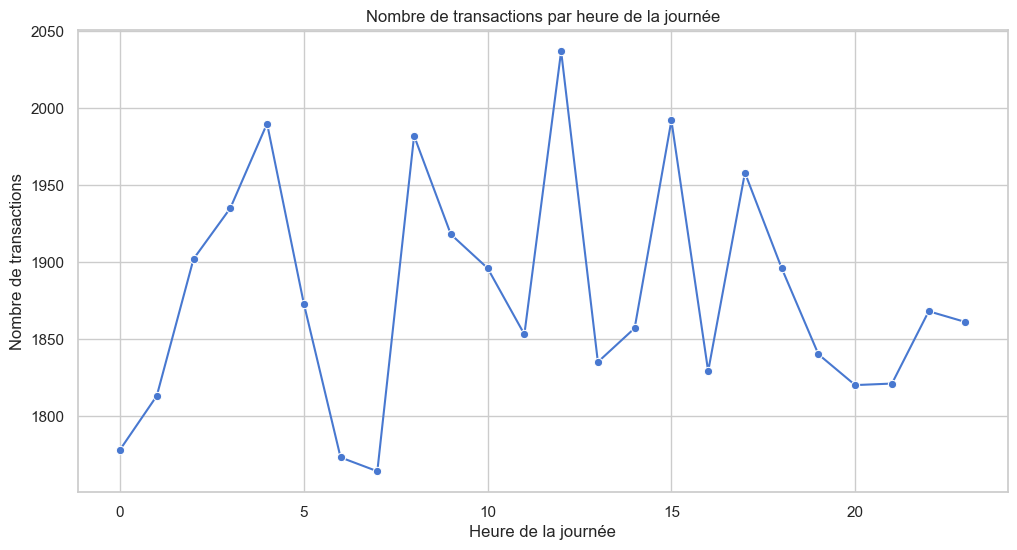

In [ ]:
# Extraire l'heure de la journée
df_merge_btob['hour'] = df_merge_btob['date'].dt.hour

# Compter le nombre de transactions par heure
transactions_by_hour_btob = df_merge_btob.groupby('hour')['session_id'].count()

# Tracer le graphique
plt.figure(figsize=(12, 6))
sns.lineplot(x=transactions_by_hour_btob.index, y=transactions_by_hour_btob.values, marker='o')
plt.title("Nombre de transactions par heure de la journée")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_5144\3289978070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_btoc['hour'] = df_merge_btoc['date'].dt.hour


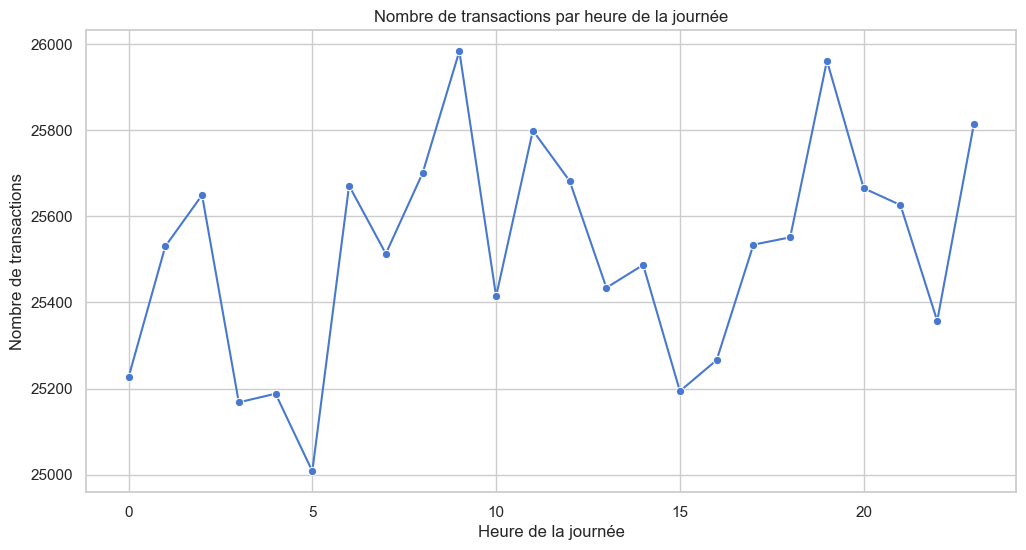

In [ ]:
# Extraire l'heure de la journée
df_merge_btoc['hour'] = df_merge_btoc['date'].dt.hour

# Compter le nombre de transactions par heure
transactions_by_hour_btoc = df_merge_btoc.groupby('hour')['session_id'].count()

# Tracer le graphique
plt.figure(figsize=(12, 6))
sns.lineplot(x=transactions_by_hour_btoc.index, y=transactions_by_hour_btoc.values, marker='o')
plt.title("Nombre de transactions par heure de la journée")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre de transactions")
plt.grid(True)
plt.show()

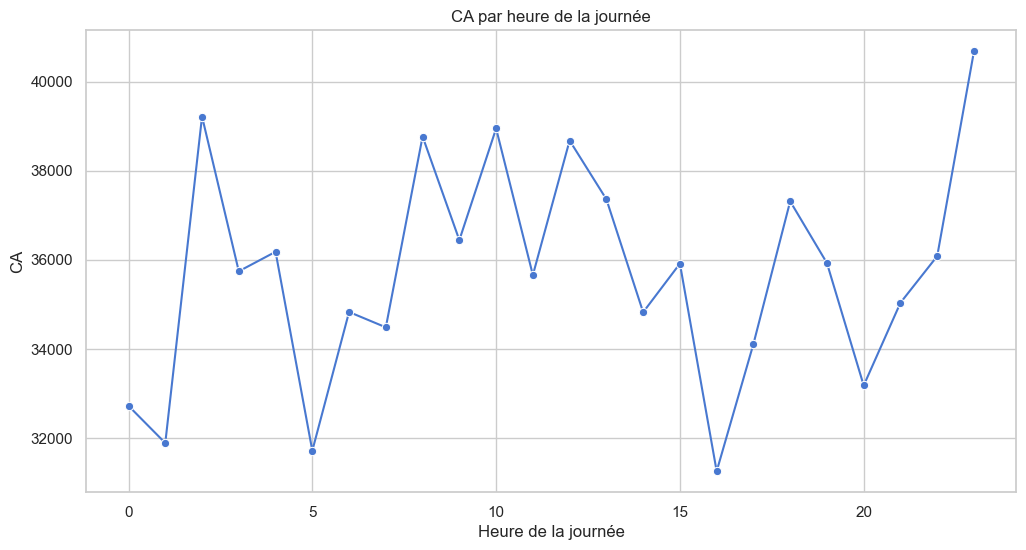

In [ ]:
# Compter le nombre de transactions par heure
ca_by_hour_btob = df_merge_btob.groupby('hour')['price'].sum()

# Tracer le graphique
plt.figure(figsize=(12, 6))
sns.lineplot(x=ca_by_hour_btob.index, y=ca_by_hour_btob.values, marker='o')
plt.title("CA par heure de la journée")
plt.xlabel("Heure de la journée")
plt.ylabel("CA")
plt.grid(True)
plt.show()

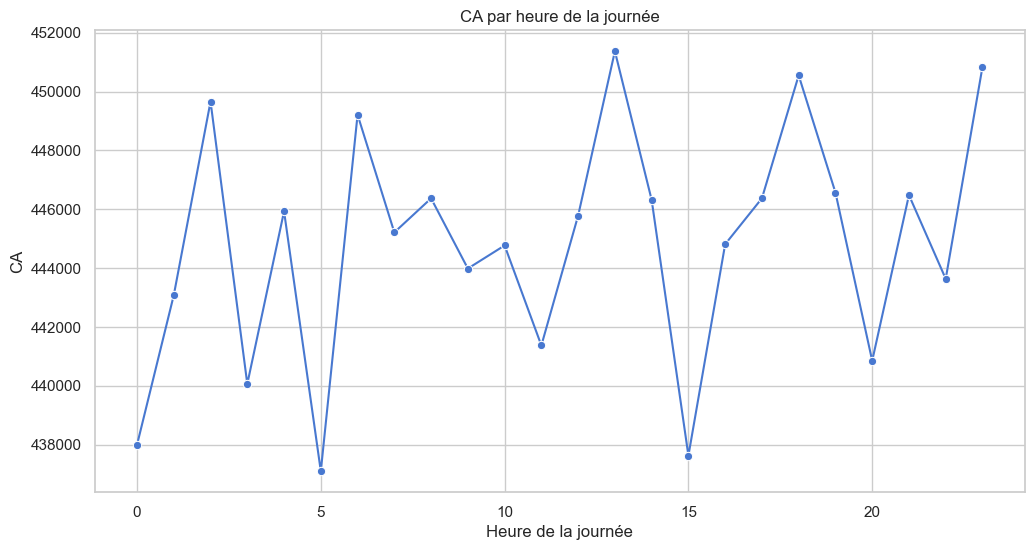

In [ ]:
# Compter le nombre de transactions par heure
ca_by_hour_btoc = df_merge_btoc.groupby('hour')['price'].sum()

# Tracer le graphique
plt.figure(figsize=(12, 6))
sns.lineplot(x=ca_by_hour_btoc.index, y=ca_by_hour_btoc.values, marker='o')
plt.title("CA par heure de la journée")
plt.xlabel("Heure de la journée")
plt.ylabel("CA")
plt.grid(True)
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">7 - Correlations</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">7.1 - Lien entre le genre d’un client et les catégories des livres achetés</h3>
</div>

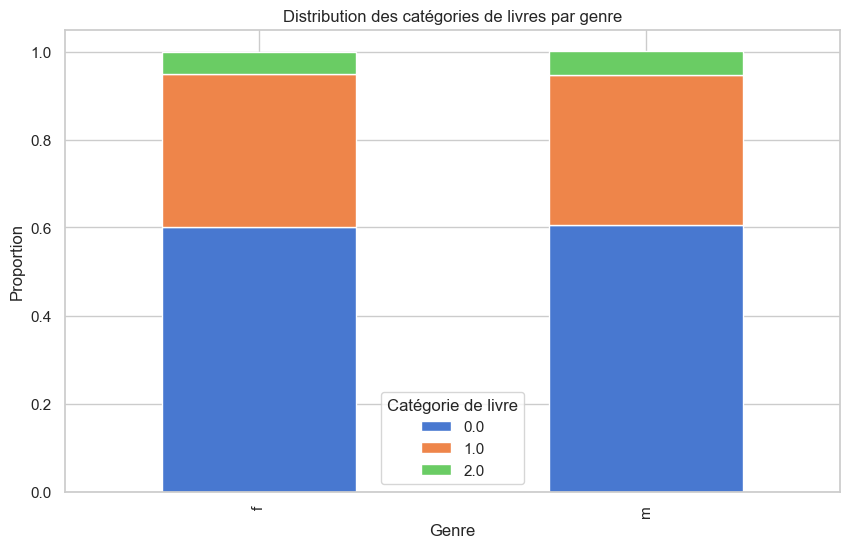

In [ ]:
# Calculer la distribution des catégories de livres par genre
genre_category_distribution = pd.crosstab(df_merge_btoc['sex'], df_merge_btoc['categ'], normalize='index')

# Tracer un graphique en barres empilées
genre_category_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Distribution des catégories de livres par genre")
plt.xlabel("Genre")
plt.ylabel("Proportion")
plt.legend(title="Catégorie de livre")
plt.show()

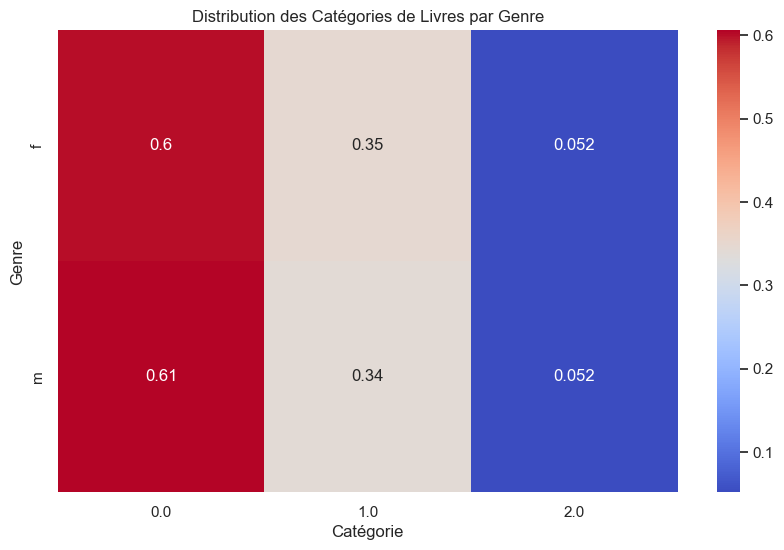

In [ ]:
# Visualisation avec une heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(genre_category_distribution, annot=True, cmap='coolwarm')
plt.title("Distribution des Catégories de Livres par Genre")
plt.xlabel("Catégorie")
plt.ylabel("Genre")
plt.show()


In [ ]:
# Créer une table de contingence
contingency_table = pd.crosstab(df_transactions['gender'], df_transactions['categ'])

# Appliquer le test du Chi-carré
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi2: {chi2}, p-value: {p}")

NameError: name 'pd' is not defined

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.2 - Lien entre l'âge des clients et le montant total des achats</h3>
</div>

In [ ]:
# Regrouper les âges en tranches d'âge
bins = [13, 18, 25, 35, 45, 55, 65, 90]
labels = ['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Créer une nouvelle colonne 'age_group' avec les tranches d'âge
df_merge_btoc['age_group'] = pd.cut(df_merge_btoc['age'], bins=bins, labels=labels, right=False)

# Vérifier la distribution des groupes d'âge
age_distribution = df_merge_btoc['age_group'].value_counts()

# Afficher la distribution des groupes d'âge
print(age_distribution)


age_group
35-44    194541
45-54    169627
25-34     74196
65+       70906
55-64     69492
18-24     31930
13-17         0
Name: count, dtype: int64


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_5144\1614720608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_btoc['age_group'] = pd.cut(df_merge_btoc['age'], bins=bins, labels=labels, right=False)


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_5144\3920153597.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='price', data=df_age_achat_total, palette='muted')


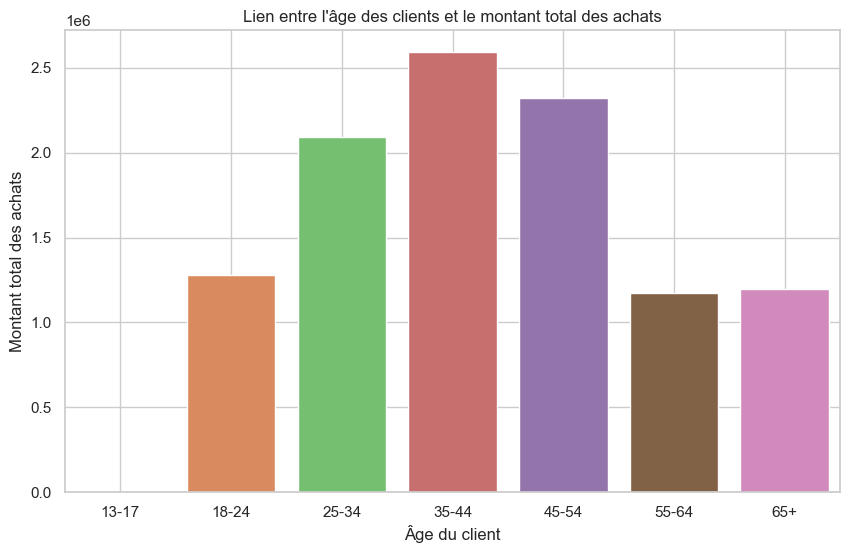

In [ ]:
# Calculer le montant total des achats par groupe d'âge
age_achat_total = df_merge_btoc.groupby('age_group', observed=False)['price'].sum()

# Créer un DataFrame à partir de la série age_achat_total
df_age_achat_total = age_achat_total.reset_index()

# Tracer le graphique avec une palette de couleurs sans utiliser `hue`, en désactivant la légende
plt.figure(figsize=(10, 6))

sns.barplot(x='age_group', y='price', data=df_age_achat_total, palette='muted')
plt.title("Lien entre l'âge des clients et le montant total des achats")
plt.xlabel("Âge du client")
plt.ylabel("Montant total des achats")
plt.grid(True)
plt.show()

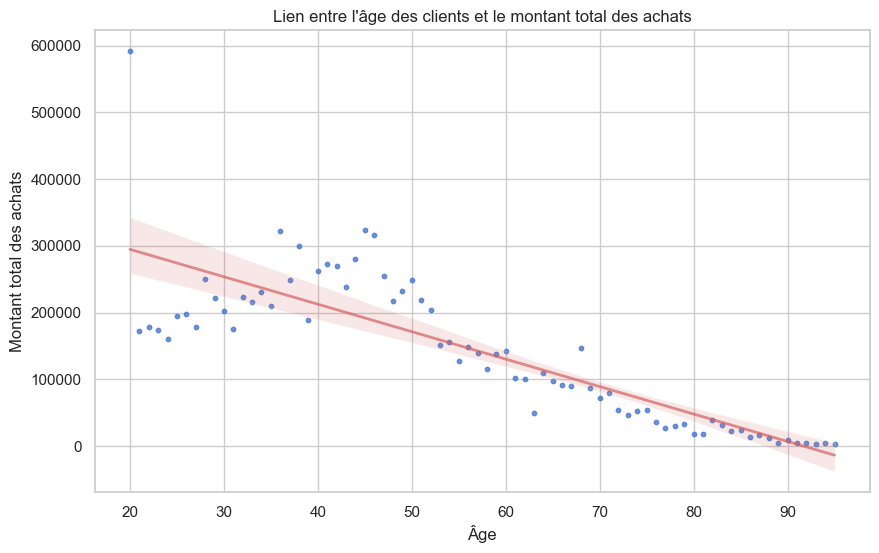

In [ ]:
# Calculer le montant total des achats par client
age_revenue = df_merge_btoc.groupby('age')['price'].sum()
# Visualisation avec un scatter plot et une ligne de régression
plt.figure(figsize=(10, 6))
sns.regplot(x=age_revenue.index, y=age_revenue.values, scatter_kws={'s':10}, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.title("Lien entre l'âge des clients et le montant total des achats")
plt.xlabel("Âge")
plt.ylabel("Montant total des achats")
plt.grid(True)
plt.show()

In [ ]:
# Utiliser les données préparées : age_revenue contient l'âge des clients et leur montant total des achats
age = age_revenue.index.values.reshape(-1, 1)  # Âge (variables indépendantes)
revenue = age_revenue.values  # Montant total des achats (variable dépendante)

# Initialiser le modèle de régression linéaire
model = LinearRegression()

# Ajuster le modèle aux données
model.fit(age, revenue)

# Prédire les valeurs avec le modèle ajusté
predictions = model.predict(age)

# Calculer l'indice de régression (R²)
r_squared = r2_score(revenue, predictions)

print(f"Indice de Régression (R²): {r_squared:.4f}")


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_5144\1391705578.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_achat_mean = df_merge_btoc.groupby('age_group')['price'].mean()
C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_5144\1391705578.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_achat_mean.index, y=age_achat_mean.values, palette='muted')


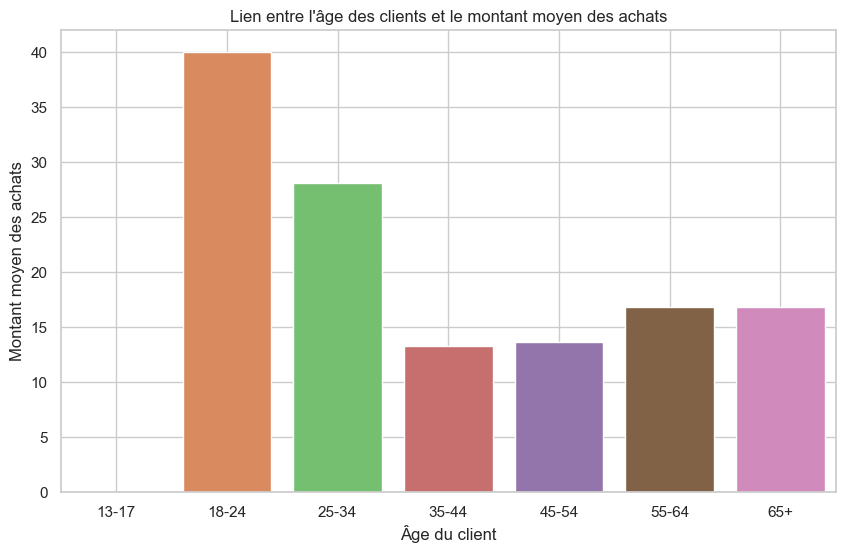

In [ ]:
# Calculer le montant moyen des achats par client
age_achat_mean = df_merge_btoc.groupby('age_group')['price'].mean()

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=age_achat_mean.index, y=age_achat_mean.values, palette='muted')
plt.title("Lien entre l'âge des clients et le montant moyen des achats")
plt.xlabel("Âge du client")
plt.ylabel("Montant moyen des achats")
plt.grid(True)
plt.show()

In [ ]:
# Calculer le montant total des achats par client
total_purchase_per_client = df_merge_btoc.groupby('client_id')['price'].sum()

# Appliquer la corrélation de Pearson entre l'âge et le montant total des achats
correlation, p_value = pearsonr(df_merge_btoc.groupby('client_id')['age'].first(), total_purchase_per_client)

print(f"Corrélation de Pearson (Âge vs Montant Total des Achats): {correlation}, p-value: {p_value}")


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.3 - Lien entre l'âge des clients et la fréquence d’achat</h3>
</div>

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_5144\3722859546.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_frequency = df_merge_btoc.groupby('age_group')['session_id'].nunique()
C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_5144\3722859546.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_frequency.index, y=age_frequency.values, palette='muted')


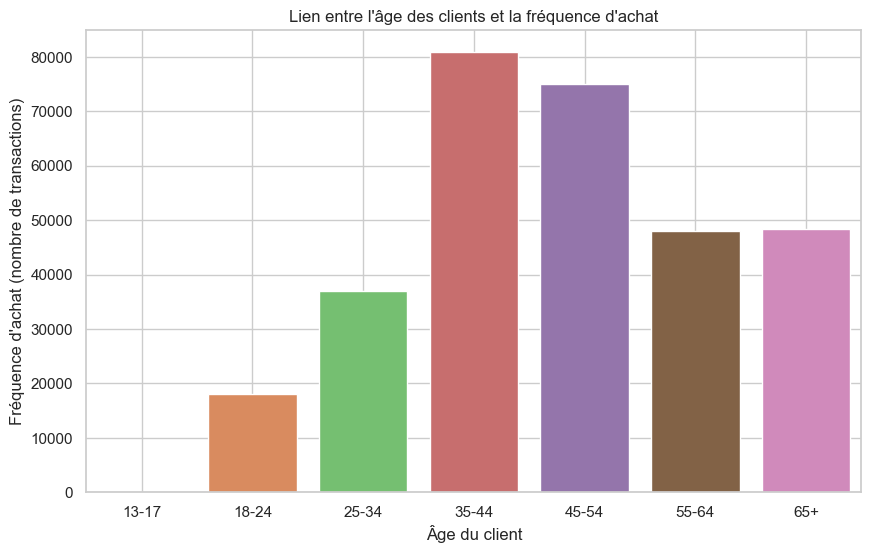

In [ ]:
# Calculer la fréquence d'achat par client
age_frequency = df_merge_btoc.groupby('age_group')['session_id'].nunique()

# Tracer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=age_frequency.index, y=age_frequency.values, palette='muted')
plt.title("Lien entre l'âge des clients et la fréquence d'achat")
plt.xlabel("Âge du client")
plt.ylabel("Fréquence d'achat (nombre de transactions)")
plt.grid(True)
plt.show()


In [ ]:
# Calculer la fréquence d'achat par client
purchase_frequency_per_client = df_merge_btoc.groupby('client_id')['session_id'].nunique()

# Groupes d'âge pour ANOVA
age_groups = df_merge_btoc.groupby('client_id')['age_goup'].first()
grouped_data = [purchase_frequency_per_client[age_groups == age_group] for age_group in age_groups.unique()]

# Appliquer ANOVA
anova_result = f_oneway(*grouped_data)
print(f"F-statistic (ANOVA pour Fréquence d'Achat par Âge): {anova_result.statistic}, p-value: {anova_result.pvalue}")


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.4 - Lien entre l'âge des clients et la taille du panier moyen</h3>
</div>

C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_5144\3785559068.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='price', data=age_basket_size2, errorbar=None, palette='muted')


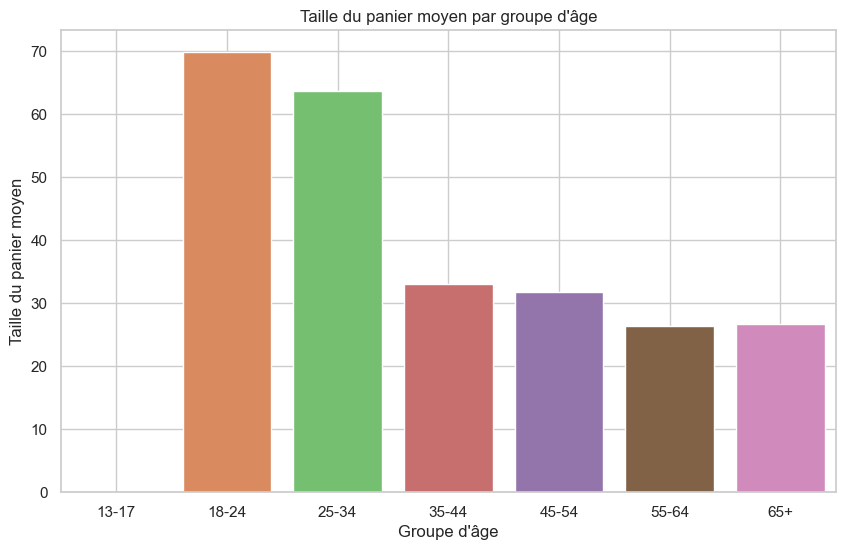

In [ ]:
# Calculer la taille du panier moyen par client
age_basket_size2 = df_merge_btoc.groupby('client_id').agg({
    'age_group': 'first',  # Utilise le groupe d'âge
    'price': lambda x: x.sum() / df_merge_btoc.loc[x.index, 'session_id'].nunique()  # Calcul du panier moyen par client
})

# Visualisation avec un barplot par groupe d'âge
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='price', data=age_basket_size2, errorbar=None, palette='muted')
plt.title("Taille du panier moyen par groupe d'âge")
plt.xlabel("Groupe d'âge")
plt.ylabel("Taille du panier moyen")
plt.grid(True)
plt.show()


In [ ]:
# Calculer la taille du panier moyen par client
panier_moyen = df_merge_btoc.groupby('client_id').apply(lambda x: x['price'].sum() / x['session_id'].nunique())

# Appliquer la corrélation de Pearson entre l'âge et la taille du panier moyen
correlation, p_value = pearsonr(df_merge_btoc.groupby('client_id')['age'].first(), panier_moyen)

print(f"Corrélation de Pearson (Âge vs Taille du Panier Moyen): {correlation}, p-value: {p_value}")

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.5 - Lien entre l'âge des clients et la catégorie des livres achetés</h3>
</div>

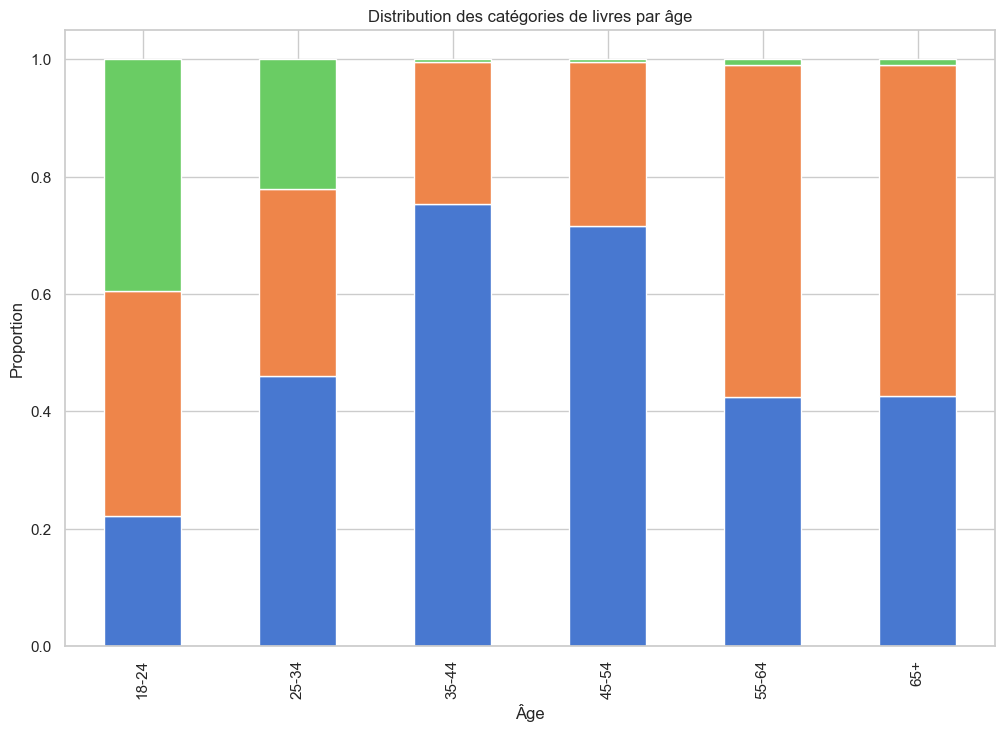

In [ ]:
# Calculer la distribution des catégories de livres par âge
age_category_distribution = pd.crosstab(df_merge_btoc['age_group'], df_merge_btoc['categ'], normalize='index')


# Tracer un graphique en barres empilées
age_category_distribution.plot(kind='bar', stacked=True, figsize=(12, 8), legend=False)
plt.title("Distribution des catégories de livres par âge")
plt.xlabel("Âge")
plt.ylabel("Proportion")
plt.show()


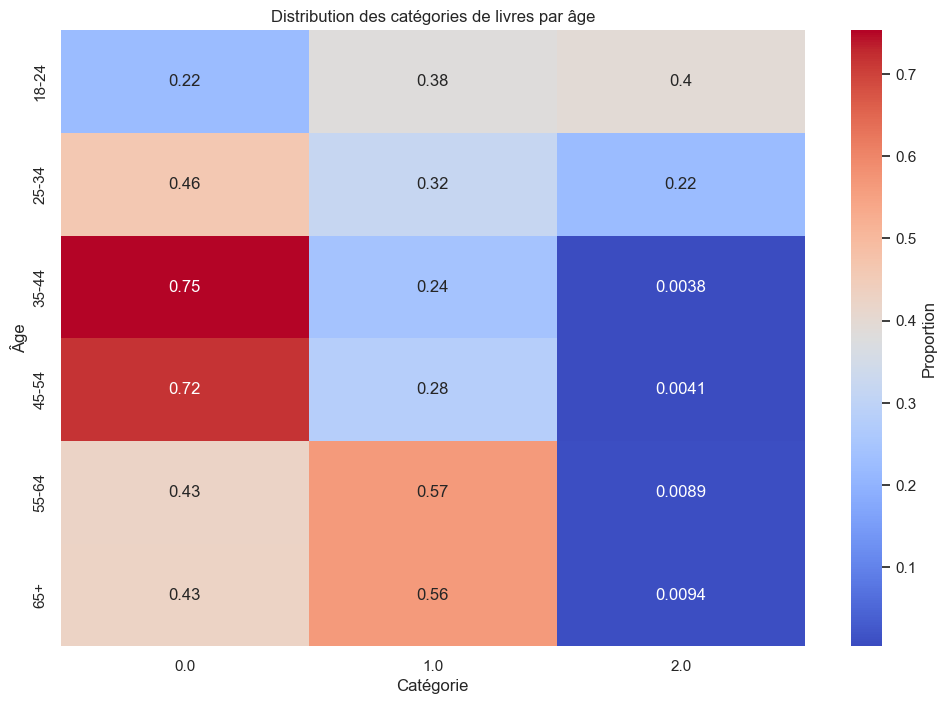

In [ ]:
# Visualisation avec une heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(age_category_distribution,  annot=True, cmap='coolwarm', cbar_kws={'label': 'Proportion'})
plt.title("Distribution des catégories de livres par âge")
plt.xlabel("Catégorie")
plt.ylabel("Âge")
plt.show()


In [ ]:
'''# Calculer la fréquence d'achat par client
purchase_frequency_per_client = df_merge_btoc.groupby('client_id')['session_id'].nunique()

# Groupes d'âge pour ANOVA
age_groups = df_merge_btoc.groupby('client_id')['age'].first()
grouped_data = [purchase_frequency_per_client[age_groups == age_group] for age_group in age_groups.unique()]

# Appliquer ANOVA
anova_result = f_oneway(*grouped_data)
print(f"F-statistic (ANOVA pour Fréquence d'Achat par Âge): {anova_result.statistic}, p-value: {anova_result.pvalue}")'''

In [ ]:
# Obtenir la liste des catégories uniques
categories = df_merge_btoc['categ'].unique()

# Initialiser un dictionnaire pour stocker les résultats de l'ANOVA
anova_results = {}

# Boucle sur chaque catégorie pour effectuer l'ANOVA
for category in categories:
    # Filtrer les données pour la catégorie en cours
    category_data = df_merge_btoc[df_merge_btoc['categ'] == category]
    
    # Calculer le nombre moyen de livres achetés par groupe d'âge
    mean_books_per_age_group = category_data.groupby('age_group')['session_id'].count() / category_data.groupby('age_group')['client_id'].nunique()

    # Groupes d'âge pour ANOVA
    grouped_data = [mean_books_per_age_group[mean_books_per_age_group.index == age_group] for age_group in mean_books_per_age_group.index.unique()]
    
    # Vérifier s'il y a plus d'un groupe pour éviter les erreurs avec ANOVA
    if len(grouped_data) > 1:
        # Appliquer ANOVA
        anova_result = f_oneway(*grouped_data)
        # Stocker le résultat dans le dictionnaire
        anova_results[category] = {
            'F-statistic': anova_result.statistic,
            'p-value': anova_result.pvalue
        }

# Afficher les résultats de l'ANOVA pour chaque catégorie
for category, result in anova_results.items():
    print(f"Catégorie: {category} - F-statistic: {result['F-statistic']:.4f}, p-value: {result['p-value']:.4f}")


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">6.6 - Table de corrélation</h3>
</div>

In [ ]:
df_merge_btoc

,date,id_prod,session_id,client_id,format_check,price,categ,sex,age,hour,age_group
0,2021-12-19 02:44:12.827475,0_1090,s_136532,c_1,Valid,13.78,0.0,m,69,2,65+
1,2021-07-25 12:17:34.446678,0_1186,s_66947,c_1,Valid,12.30,0.0,m,69,12,65+
2,2022-08-25 12:17:34.446678,0_1186,s_258252,c_1,Valid,12.30,0.0,m,69,12,65+
3,2021-08-23 16:56:15.401655,0_1378,s_79696,c_1,Valid,13.96,0.0,m,69,16,65+
4,2022-07-23 16:56:15.401655,0_1378,s_242617,c_1,Valid,13.96,0.0,m,69,16,65+
...,...,...,...,...,...,...,...,...,...,...,...
612443,2022-01-19 09:10:14.900805,1_724,s_152063,c_999,Valid,16.94,1.0,m,60,9,55-64
612444,2021-11-21 17:40:50.856434,1_727,s_122996,c_999,Valid,16.99,1.0,m,60,17,55-64
612445,2022-05-21 17:40:50.856434,1_727,s_211960,c_999,Valid,16.99,1.0,m,60,17,55-64
612446,2022-07-21 17:40:50.856434,1_727,s_241673,c_999,Valid,16.99,1.0,m,60,17,55-64


In [ ]:
# Calculer le montant total des achats par client
total_purchase_per_client = df_merge_btoc.groupby('client_id')['price'].sum()

# Calculer la fréquence d'achat par client (nombre de transactions)
purchase_frequency_per_client = df_merge_btoc.groupby('client_id')['session_id'].nunique()

# Calculer la taille du panier moyen par client
panier_moyen = df_merge_btoc.groupby('client_id').apply(lambda x: x['price'].sum() / x['session_id'].nunique())

# Créer un DataFrame avec toutes les variables
df_correlation = pd.DataFrame({
    'age': df_merge_btoc.groupby('client_id')['age'].first(),
    'total_achat': total_purchase_per_client,
    'frenquence_achat': purchase_frequency_per_client,
    'panier_moyen': panier_moyen,
})

# Afficher les premières lignes pour vérification
df_correlation.head()


C:\Users\ZAPHAS\AppData\Local\Temp\ipykernel_5144\2932324993.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panier_moyen = df_merge_btoc.groupby('client_id').apply(lambda x: x['price'].sum() / x['session_id'].nunique())


,age,total_achat,frenquence_achat,panier_moyen
client_id,,,,
c_1,69,550.19,32,17.193438
c_10,68,1353.60,34,39.811765
c_100,32,254.85,5,50.970000
c_1000,58,2209.92,91,24.284835
c_1001,42,1720.08,44,39.092727


In [ ]:
# Calculer la matrice de corrélation
correlation_matrix = df_correlation.corr()

# Afficher la matrice de corrélation
print(correlation_matrix)


                       age  total_achat  frenquence_achat  panier_moyen
age               1.000000    -0.183747          0.167559     -0.610013
total_achat      -0.183747     1.000000          0.822485      0.160647
frenquence_achat  0.167559     0.822485          1.000000     -0.307498
panier_moyen     -0.610013     0.160647         -0.307498      1.000000


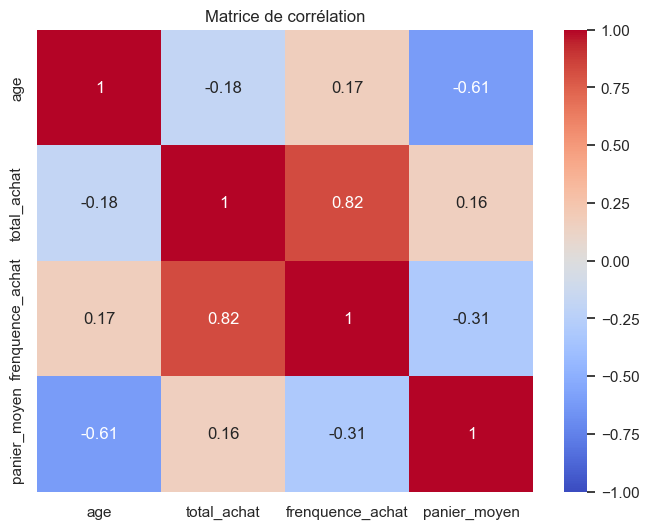

In [ ]:
# Tracer la heatmap de la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de corrélation")
plt.show()
